In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

import qutip as qp

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation


In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [6]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [7]:
def density_matrix_from_bloch_vector(bloch_vector):
   rho = 0.5 * (I+ bloch_vector[0]*X + bloch_vector[1]*Y + bloch_vector[2]*Z)
   return rho

In [8]:
sim_bknd=Aer.get_backend('aer_simulator')

In [9]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Noise Models

In [10]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [11]:
#RECAP of Identity and Pauli matrices
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [12]:
#BIT FLIP, PHASE FLIP AND BIT-PHASE FLIP ERROR

def flip_error(num_qubits, rho, error_type, p):

    E_0 = np.sqrt(1-p)*I
    if error_type == 'bit':
        E_1 = np.sqrt(p)*X
    if error_type == 'phase':
        E_1 = np.sqrt(p)*Z
    if error_type == 'bp':
        E_1 = np.sqrt(p)*Y
        
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

In [13]:
#GENERAL PAULI ERROR (generalizes and allows to combine the flip errors)

def g_pauli_error(num_qubits, rho, p_0, p_1, p_2, p_3):
    
    E_0 = np.sqrt(p_0)*I
    E_1 = np.sqrt(p_1)*X
    E_2 = np.sqrt(p_2)*Y
    E_3 = np.sqrt(p_3)*Z
    
    rho_with_gpauli_error = sum_element(rho, E_0)+sum_element(rho, E_1)+sum_element(rho, E_2)+sum_element(rho, E_3)
    
    return rho_with_gpauli_error

In [14]:
# DEPOLARIZING ERROR

def depolar_error(num_qubits, rho, p):
    
    rho_with_dep_error = p*I/2 + (1-p)*rho

    return rho_with_dep_error

In [15]:
#GENERAL AMPLITUDE DAMPING ERROR

def ampl_damp_error(num_qubits, rho, p, a):
  
    E_0 = np.sqrt(p)*np.array([[1, 0], [0, np.sqrt(1-a)]])
    E_1 = np.sqrt(p)*np.array([[0, np.sqrt(a)], [0, 0]])
    E_2 = np.sqrt(1-p)*np.array([[np.sqrt(1-a), 0], [0, 1]])
    E_3 = np.sqrt(1-p)*np.array([[0, 0], [np.sqrt(a), 0]])
    
    rho_with_ad_error = sum_element(rho, E_0)+sum_element(rho, E_1)+sum_element(rho, E_2)+sum_element(rho, E_3)

    return rho_with_ad_error

In [16]:
#KRAUS ERROR

def kr_error(num_qubits, rho, alpha, beta):
    
    A_0 = np.array([[np.cos(alpha), 0], [0, np.cos(beta)]])
    A_1 = np.array([[0, np.sin(beta)], [np.sin(alpha), 0]])
    
    rho_with_kraus_error = sum_element(rho, A_0)+sum_element(rho, A_1)
    
    return rho_with_kraus_error

## Binary Classification (phase vs amplitude)
In this section, we construct a dataset which contains quantum states which can undergo into two different errors: phase error (p=0.2) and amplitude damping error (p=0.5, a= 0.3). We can see that, given a dataset of few hundreds of samples, the network is able to distinguish among the errors with almost certainty (90% of confidence) and it correctly classifies all the samples. 
Notice that the dataset is composed by a six-component vector, representing the noisy Bloch vector appended to the noise-free one, and the label, in which 0 stands for phase flip error while 1 for amplitude damping error. The network reaches a validation accuracy of 1 is with one hundred epochs, even if the loss function continues to decrease (making the decision process more reliable, increasing the probability of the correct class).

In [17]:
num_samples = 400
data = generate_Haar_data(1, num_samples)

In [18]:
density_matrix_noise_free = [*map(get_density_matrix, data)]
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

In [19]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(num_samples):
  if (i%2==0): 
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)
  else:
    single_data_with_noise = ampl_damp_error(1, density_matrix_noise_free[i], 0.5, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)  
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [20]:
x_dataset = []
for i in range(num_samples):
   element = np.concatenate((bloch_vectors_with_noise[i], bloch_vectors_noise_free[i]))
   x_dataset.append(element)

print(x_dataset[0])

[ 0.17591575  0.44877723 -0.59547518  0.29319292  0.74796205 -0.59547518]


In [21]:
first_slice_value = 320
last_slice_value = 360

#Splitting the dataset
x_train_list, x_val_list, x_test_list = x_dataset[:first_slice_value], x_dataset[first_slice_value:last_slice_value], x_dataset[last_slice_value:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
x_val = tf.convert_to_tensor(x_val_list)
x_test = tf.convert_to_tensor(x_test_list)

#Defining the labels (Phase Error = 0, Amplitude Damping Error = 1)
y_label_train = [0,1] * int(first_slice_value/2)
y_label_val = [0,1] * int((last_slice_value - first_slice_value)/2)
y_label_test = [0,1] * int((last_slice_value - first_slice_value)/2)

#Convert to tensors
y_train = tf.convert_to_tensor(y_label_train)
y_val = tf.convert_to_tensor(y_label_val)
y_test = tf.convert_to_tensor(y_label_test)

#Define the one-hot vectors
y_train_oh = tf.keras.utils.to_categorical(y_train, 2)
y_val_oh = tf.keras.utils.to_categorical(y_val, 2)
y_test_oh = tf.keras.utils.to_categorical(y_test, 2)

In [22]:
# Define Model
model = tf.keras.models.Sequential([                               
  tf.keras.layers.InputLayer(input_shape=(6,)),                            
  tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dense(16, activation='relu'),     
  tf.keras.layers.Dense(2, activation = 'softmax')
  ])

In [23]:
adam_opt = tf.optimizers.Adam(0.005)
# Compile model
model.compile(loss='categorical_crossentropy',
             optimizer=adam_opt,
             metrics=['accuracy'])

In [24]:
# Train Model
history = model.fit(x_train,
         y_train_oh,
         batch_size=40,
         epochs=300,
         validation_data=(x_val, y_val_oh))

Epoch 1/300
8/8 [==============================] - 1s 59ms/step - loss: 0.6890 - accuracy: 0.5375 - val_loss: 0.7111 - val_accuracy: 0.4250
Epoch 2/300
8/8 [==============================] - 0s 8ms/step - loss: 0.6696 - accuracy: 0.6187 - val_loss: 0.6992 - val_accuracy: 0.4500
Epoch 3/300
8/8 [==============================] - 0s 8ms/step - loss: 0.6617 - accuracy: 0.6281 - val_loss: 0.7004 - val_accuracy: 0.4250
Epoch 4/300
8/8 [==============================] - 0s 7ms/step - loss: 0.6528 - accuracy: 0.6313 - val_loss: 0.6911 - val_accuracy: 0.4500
Epoch 5/300
8/8 [==============================] - 0s 8ms/step - loss: 0.6436 - accuracy: 0.6313 - val_loss: 0.6832 - val_accuracy: 0.4500
Epoch 6/300
8/8 [==============================] - 0s 8ms/step - loss: 0.6340 - accuracy: 0.6281 - val_loss: 0.6840 - val_accuracy: 0.4500
Epoch 7/300
8/8 [==============================] - 0s 8ms/step - loss: 0.6220 - accuracy: 0.6375 - val_loss: 0.6624 - val_accuracy: 0.5000
Epoch 8/300
8/8 [=========

8/8 [==============================] - 0s 7ms/step - loss: 3.7161e-04 - accuracy: 1.0000 - val_loss: 4.1106e-04 - val_accuracy: 1.0000
Epoch 116/300
8/8 [==============================] - 0s 7ms/step - loss: 3.6451e-04 - accuracy: 1.0000 - val_loss: 4.0773e-04 - val_accuracy: 1.0000
Epoch 117/300
8/8 [==============================] - 0s 7ms/step - loss: 3.5718e-04 - accuracy: 1.0000 - val_loss: 4.0284e-04 - val_accuracy: 1.0000
Epoch 118/300
8/8 [==============================] - 0s 7ms/step - loss: 3.4954e-04 - accuracy: 1.0000 - val_loss: 3.9399e-04 - val_accuracy: 1.0000
Epoch 119/300
8/8 [==============================] - 0s 7ms/step - loss: 3.4344e-04 - accuracy: 1.0000 - val_loss: 3.8685e-04 - val_accuracy: 1.0000
Epoch 120/300
8/8 [==============================] - 0s 7ms/step - loss: 3.3666e-04 - accuracy: 1.0000 - val_loss: 3.8081e-04 - val_accuracy: 1.0000
Epoch 121/300
8/8 [==============================] - 0s 7ms/step - loss: 3.3024e-04 - accuracy: 1.0000 - val_loss: 3.711

8/8 [==============================] - 0s 8ms/step - loss: 1.5209e-04 - accuracy: 1.0000 - val_loss: 1.7651e-04 - val_accuracy: 1.0000
Epoch 171/300
8/8 [==============================] - 0s 8ms/step - loss: 1.5003e-04 - accuracy: 1.0000 - val_loss: 1.7461e-04 - val_accuracy: 1.0000
Epoch 172/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4837e-04 - accuracy: 1.0000 - val_loss: 1.7304e-04 - val_accuracy: 1.0000
Epoch 173/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4617e-04 - accuracy: 1.0000 - val_loss: 1.7136e-04 - val_accuracy: 1.0000
Epoch 174/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4411e-04 - accuracy: 1.0000 - val_loss: 1.6931e-04 - val_accuracy: 1.0000
Epoch 175/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4239e-04 - accuracy: 1.0000 - val_loss: 1.6583e-04 - val_accuracy: 1.0000
Epoch 176/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4042e-04 - accuracy: 1.0000 - val_loss: 1.653

8/8 [==============================] - 0s 7ms/step - loss: 7.9707e-05 - accuracy: 1.0000 - val_loss: 9.6260e-05 - val_accuracy: 1.0000
Epoch 226/300
8/8 [==============================] - 0s 8ms/step - loss: 7.8761e-05 - accuracy: 1.0000 - val_loss: 9.4940e-05 - val_accuracy: 1.0000
Epoch 227/300
8/8 [==============================] - 0s 7ms/step - loss: 7.7937e-05 - accuracy: 1.0000 - val_loss: 9.4007e-05 - val_accuracy: 1.0000
Epoch 228/300
8/8 [==============================] - 0s 7ms/step - loss: 7.7215e-05 - accuracy: 1.0000 - val_loss: 9.3870e-05 - val_accuracy: 1.0000
Epoch 229/300
8/8 [==============================] - 0s 8ms/step - loss: 7.6435e-05 - accuracy: 1.0000 - val_loss: 9.1522e-05 - val_accuracy: 1.0000
Epoch 230/300
8/8 [==============================] - 0s 8ms/step - loss: 7.5586e-05 - accuracy: 1.0000 - val_loss: 9.0857e-05 - val_accuracy: 1.0000
Epoch 231/300
8/8 [==============================] - 0s 8ms/step - loss: 7.4798e-05 - accuracy: 1.0000 - val_loss: 8.997

8/8 [==============================] - 0s 8ms/step - loss: 4.7190e-05 - accuracy: 1.0000 - val_loss: 5.8037e-05 - val_accuracy: 1.0000
Epoch 281/300
8/8 [==============================] - 0s 7ms/step - loss: 4.6740e-05 - accuracy: 1.0000 - val_loss: 5.8079e-05 - val_accuracy: 1.0000
Epoch 282/300
8/8 [==============================] - 0s 9ms/step - loss: 4.6345e-05 - accuracy: 1.0000 - val_loss: 5.7447e-05 - val_accuracy: 1.0000
Epoch 283/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5998e-05 - accuracy: 1.0000 - val_loss: 5.6645e-05 - val_accuracy: 1.0000
Epoch 284/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5576e-05 - accuracy: 1.0000 - val_loss: 5.6181e-05 - val_accuracy: 1.0000
Epoch 285/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5216e-05 - accuracy: 1.0000 - val_loss: 5.6261e-05 - val_accuracy: 1.0000
Epoch 286/300
8/8 [==============================] - 0s 9ms/step - loss: 4.4847e-05 - accuracy: 1.0000 - val_loss: 5.548

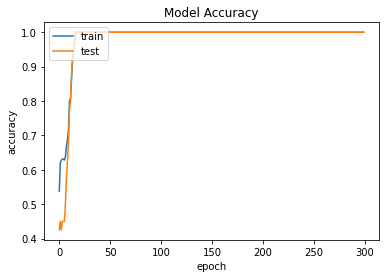

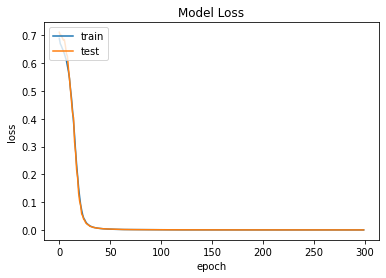

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test_oh, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [27]:
y_tilde = model.predict(x_test)
for i in range(len(x_test)):
  print(i, "Prediction: {}, True label: {}".format(y_tilde[i], y_test[i]))

2/2 [==============================] - 0s 4ms/step
0 Prediction: [9.9988127e-01 1.1876873e-04], True label: 0
1 Prediction: [3.351551e-05 9.999665e-01], True label: 1
2 Prediction: [9.999832e-01 1.676311e-05], True label: 0
3 Prediction: [3.2731252e-05 9.9996722e-01], True label: 1
4 Prediction: [9.9999571e-01 4.3430578e-06], True label: 0
5 Prediction: [2.3275967e-05 9.9997675e-01], True label: 1
6 Prediction: [9.999571e-01 4.293962e-05], True label: 0
7 Prediction: [7.9759520e-05 9.9992025e-01], True label: 1
8 Prediction: [9.9980754e-01 1.9244060e-04], True label: 0
9 Prediction: [3.5974812e-05 9.9996400e-01], True label: 1
10 Prediction: [9.999099e-01 9.017302e-05], True label: 0
11 Prediction: [2.107157e-05 9.999789e-01], True label: 1
12 Prediction: [9.9998581e-01 1.4142159e-05], True label: 0
13 Prediction: [2.1422953e-05 9.9997854e-01], True label: 1
14 Prediction: [9.9990475e-01 9.5234755e-05], True label: 0
15 Prediction: [6.295010e-06 9.999937e-01], True label: 1
16 Predicti

## Binary Classification (amplitude vs depolarizing)

In [28]:
num_samples = 2000
data = generate_Haar_data(1, num_samples)

In [29]:
density_matrix_noise_free = [*map(get_density_matrix, data)]
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

In [30]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(num_samples):
  if (i%2==0): 
    single_data_with_noise = depolar_error(1, density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)
  else:
    single_data_with_noise = ampl_damp_error(1, density_matrix_noise_free[i], 0.5, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)  
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [31]:
x_dataset = []
for i in range(num_samples):
   element = np.concatenate((bloch_vectors_with_noise[i], bloch_vectors_noise_free[i]))
   x_dataset.append(element)

In [32]:
first_slice_value = 1600
last_slice_value = 1800

#Splitting the dataset
x_train_list, x_val_list, x_test_list = x_dataset[:first_slice_value], x_dataset[first_slice_value:last_slice_value], x_dataset[last_slice_value:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
x_val = tf.convert_to_tensor(x_val_list)
x_test = tf.convert_to_tensor(x_test_list)

#Defining the labels (Phase Error = 0, Amplitude Damping Error = 1)
y_label_train = [0,1] * int(first_slice_value/2)
y_label_val = [0,1] * int((last_slice_value - first_slice_value)/2)
y_label_test = [0,1] * int((last_slice_value - first_slice_value)/2)

#Convert to tensors
y_train = tf.convert_to_tensor(y_label_train)
y_val = tf.convert_to_tensor(y_label_val)
y_test = tf.convert_to_tensor(y_label_test)

#Define the one-hot vectors
y_train_oh = tf.keras.utils.to_categorical(y_train, 2)
y_val_oh = tf.keras.utils.to_categorical(y_val, 2)
y_test_oh = tf.keras.utils.to_categorical(y_test, 2)

In [33]:
# Define Model
model = tf.keras.models.Sequential([                                                         
  tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dense(16, activation='relu'),     
  tf.keras.layers.Dense(2, activation = 'softmax')
  ])

In [34]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(loss='categorical_crossentropy',
             optimizer=adam_opt,
             metrics=['accuracy'])

In [35]:
# Train Model
history = model.fit(x_train,
         y_train_oh,
         batch_size=150,
         epochs=1000,
         validation_data=(x_val, y_val_oh))

Epoch 1/1000
11/11 [==============================] - 1s 28ms/step - loss: 0.7165 - accuracy: 0.4938 - val_loss: 0.6924 - val_accuracy: 0.5050
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.7012 - accuracy: 0.5050 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.5025 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.5150 - val_loss: 0.6939 - val_accuracy: 0.4950
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5188 - val_loss: 0.6954 - val_accuracy: 0.4850
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5075 - val_loss: 0.6966 - val_accuracy: 0.4750
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5281 - val_loss: 0.6976 - val_accuracy: 0.4850
Epoch

11/11 [==============================] - 0s 6ms/step - loss: 0.5616 - accuracy: 0.7656 - val_loss: 0.5533 - val_accuracy: 0.8700
Epoch 116/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.5463 - accuracy: 0.7931 - val_loss: 0.5455 - val_accuracy: 0.8900
Epoch 117/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.5511 - accuracy: 0.7862 - val_loss: 0.5440 - val_accuracy: 0.8850
Epoch 118/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.5358 - accuracy: 0.8081 - val_loss: 0.5308 - val_accuracy: 0.9150
Epoch 119/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8125 - val_loss: 0.5271 - val_accuracy: 0.8800
Epoch 120/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.5213 - accuracy: 0.8200 - val_loss: 0.5168 - val_accuracy: 0.9250
Epoch 121/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.5093 - accuracy: 0.8444 - val_loss: 0.5101 - val_accuracy: 0.8850
Epoch 1

Epoch 172/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.2077 - accuracy: 0.9725 - val_loss: 0.1894 - val_accuracy: 1.0000
Epoch 173/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.1980 - accuracy: 0.9675 - val_loss: 0.1893 - val_accuracy: 0.9900
Epoch 174/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.2035 - accuracy: 0.9681 - val_loss: 0.1788 - val_accuracy: 1.0000
Epoch 175/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.2045 - accuracy: 0.9581 - val_loss: 0.1867 - val_accuracy: 1.0000
Epoch 176/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.1965 - accuracy: 0.9656 - val_loss: 0.1749 - val_accuracy: 1.0000
Epoch 177/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.9650 - val_loss: 0.1758 - val_accuracy: 0.9950
Epoch 178/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.1860 - accuracy: 0.9719 - val_loss: 0.1740 - val_accuracy:

Epoch 229/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0977 - accuracy: 0.9894 - val_loss: 0.0826 - val_accuracy: 1.0000
Epoch 230/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0938 - accuracy: 0.9937 - val_loss: 0.0835 - val_accuracy: 1.0000
Epoch 231/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0981 - accuracy: 0.9869 - val_loss: 0.0812 - val_accuracy: 1.0000
Epoch 232/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0916 - accuracy: 0.9937 - val_loss: 0.0792 - val_accuracy: 1.0000
Epoch 233/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0930 - accuracy: 0.9900 - val_loss: 0.0788 - val_accuracy: 1.0000
Epoch 234/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0939 - accuracy: 0.9925 - val_loss: 0.0817 - val_accuracy: 1.0000
Epoch 235/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0965 - accuracy: 0.9887 - val_loss: 0.0809 - val_accuracy:

Epoch 286/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0581 - accuracy: 0.9962 - val_loss: 0.0477 - val_accuracy: 1.0000
Epoch 287/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0611 - accuracy: 0.9944 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 288/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9956 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 289/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0595 - accuracy: 0.9931 - val_loss: 0.0456 - val_accuracy: 1.0000
Epoch 290/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0574 - accuracy: 0.9950 - val_loss: 0.0446 - val_accuracy: 1.0000
Epoch 291/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9925 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 292/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0589 - accuracy: 0.9950 - val_loss: 0.0447 - val_accuracy:

Epoch 343/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0398 - accuracy: 0.9962 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 344/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9925 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 345/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9969 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 346/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9956 - val_loss: 0.0275 - val_accuracy: 1.0000
Epoch 347/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9981 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 348/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0374 - accuracy: 0.9956 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 349/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0363 - accuracy: 0.9994 - val_loss: 0.0272 - val_accuracy:

Epoch 400/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9975 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 401/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0275 - accuracy: 0.9969 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 402/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9975 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 403/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0255 - accuracy: 0.9994 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 404/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0255 - accuracy: 0.9975 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 405/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0262 - accuracy: 0.9975 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 406/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0271 - accuracy: 0.9956 - val_loss: 0.0193 - val_accuracy:

Epoch 457/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9975 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 458/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9969 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 459/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9981 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 460/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9962 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 461/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 462/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9981 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 463/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9969 - val_loss: 0.0127 - val_accuracy:

Epoch 514/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 515/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 516/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9981 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 517/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 0.9969 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 518/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0128 - accuracy: 0.9987 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 519/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.9981 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 520/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0141 - accuracy: 0.9981 - val_loss: 0.0084 - val_accuracy:

Epoch 571/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9994 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 572/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 573/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 574/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 575/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0098 - accuracy: 0.9994 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 576/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 577/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0117 - accuracy: 0.9981 - val_loss: 0.0060 - val_accuracy:

Epoch 628/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.9981 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 629/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 630/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0115 - accuracy: 0.9981 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 631/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 0.9987 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 632/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 633/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 634/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy:

Epoch 685/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0108 - accuracy: 0.9994 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 686/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0089 - accuracy: 0.9981 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 687/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 688/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 689/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 690/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 691/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.0030 - val_accuracy:

Epoch 742/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 743/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0084 - accuracy: 0.9994 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 744/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 745/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 746/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 747/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0062 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 748/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0063 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy:

Epoch 799/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 800/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 801/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 802/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 803/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 804/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 805/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy:

Epoch 856/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 857/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 858/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 859/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 860/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 861/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 862/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0029 - val_accuracy:

Epoch 913/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 914/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 915/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0045 - accuracy: 0.9981 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 916/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 9.7992e-04 - val_accuracy: 1.0000
Epoch 917/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0055 - accuracy: 0.9975 - val_loss: 9.8050e-04 - val_accuracy: 1.0000
Epoch 918/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 919/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0018 - val_a

Epoch 970/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 971/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 0.9994 - val_loss: 9.5215e-04 - val_accuracy: 1.0000
Epoch 972/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 973/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 974/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 975/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 976/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 8.6657e-04 - val_a

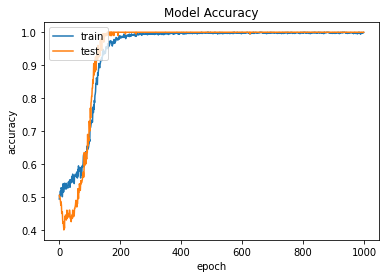

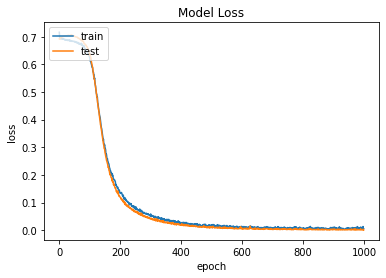

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test_oh, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [38]:
y_tilde = model.predict(x_test)
for i in range(len(x_test)):
  print(i, "Prediction: {}, True label: {}".format(y_tilde[i], y_test[i]))

7/7 [==============================] - 0s 2ms/step
0 Prediction: [9.9999988e-01 1.2950743e-07], True label: 0
1 Prediction: [1.1189514e-12 1.0000000e+00], True label: 1
2 Prediction: [9.9998808e-01 1.1944805e-05], True label: 0
3 Prediction: [0.00260245 0.99739754], True label: 1
4 Prediction: [9.999993e-01 7.261660e-07], True label: 0
5 Prediction: [4.2584195e-04 9.9957412e-01], True label: 1
6 Prediction: [1.0000000e+00 2.4642428e-14], True label: 0
7 Prediction: [1.0062286e-17 1.0000000e+00], True label: 1
8 Prediction: [0.998489   0.00151096], True label: 0
9 Prediction: [4.5436695e-06 9.9999547e-01], True label: 1
10 Prediction: [9.9999976e-01 2.2574818e-07], True label: 0
11 Prediction: [4.0536048e-07 9.9999964e-01], True label: 1
12 Prediction: [1.0000000e+00 1.3308176e-11], True label: 0
13 Prediction: [9.116318e-11 1.000000e+00], True label: 1
14 Prediction: [1.0000000e+00 1.1970384e-17], True label: 0
15 Prediction: [1.9495418e-04 9.9980503e-01], True label: 1
16 Prediction: 

152 Prediction: [0.99429274 0.00570726], True label: 0
153 Prediction: [6.1633320e-05 9.9993837e-01], True label: 1
154 Prediction: [9.9912316e-01 8.7686145e-04], True label: 0
155 Prediction: [1.2704691e-04 9.9987292e-01], True label: 1
156 Prediction: [1.0000000e+00 1.4128955e-17], True label: 0
157 Prediction: [2.939103e-14 1.000000e+00], True label: 1
158 Prediction: [0.9787441  0.02125592], True label: 0
159 Prediction: [1.239532e-21 1.000000e+00], True label: 1
160 Prediction: [0.9966468  0.00335318], True label: 0
161 Prediction: [8.168752e-28 1.000000e+00], True label: 1
162 Prediction: [9.999094e-01 9.062835e-05], True label: 0
163 Prediction: [8.987138e-20 1.000000e+00], True label: 1
164 Prediction: [9.999999e-01 1.109643e-07], True label: 0
165 Prediction: [3.3244386e-04 9.9966753e-01], True label: 1
166 Prediction: [9.9999285e-01 7.1344602e-06], True label: 0
167 Prediction: [1.05540764e-10 1.00000000e+00], True label: 1
168 Prediction: [9.9999976e-01 2.6300327e-07], True 

## Binary Classification with noisy dataset

In this section, we propose again the problem of binary classification but with a variation: in this case the dataset is only composed by the noisy Bloch vector. The network has to investigate hidden relationships among the training data and the corresponding effect on the Bloch sphere. We expect the network to learn the different transformations in which the Bloch sphere goes when a particular error is applied. In fact, for the phase flip error the x-y plane of Bloch sphere is uniformly contracted by a factor *1-2p*, while the states of the z-axis are left alone. Instead, for the amplitude damping error, the sphere shrinks towards a given point (determined by the parameter a) along the z-axis. 

We can see that the amount of data required for this task is higher than the previous case because we have provided less informative data to the network. Moreover, the network doesn't reach accuracy 1 and it makes sense: some samples could belong reasonably to both classes and the model can't decide how to classify them (probably the two different bloch spheres have a not trivial intersection); this also explains the instability of the valuation curves in trying to classify ambiguous samples. 

Finally, also the network must be more complex: more hidden layers are required!

In [17]:
num_samples = 5000
data = generate_Haar_data(1, num_samples)

In [18]:
density_matrix_noise_free = [*map(get_density_matrix, data)]
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

In [19]:
#APPLY ERROR 
density_matrix_with_noise = []
den_ad_with_noise = []
den_pf_with_noise = []
for i in range(num_samples):
  if (i%2==0): 
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)
    den_pf_with_noise.append(single_data_with_noise)
  else:
    single_data_with_noise = ampl_damp_error(1, density_matrix_noise_free[i], 0.5, 0.3)
    density_matrix_with_noise.append(single_data_with_noise) 
    den_ad_with_noise.append(single_data_with_noise)
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
blo_vectors_with_noise = [*map(Bloch_vector, den_ad_with_noise)]
b_vec_with_noise = [*map(Bloch_vector, den_pf_with_noise)]

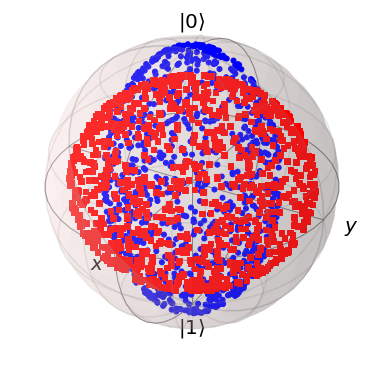

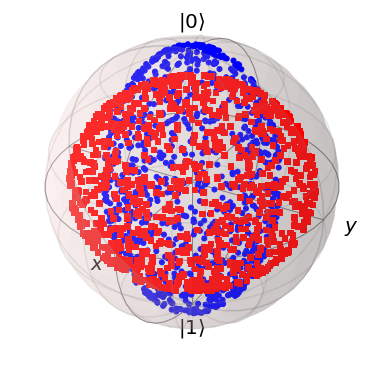

In [20]:
b = qp.Bloch()

xp = [b_vec_with_noise[i][0] for i in range(1000)]
yp = [b_vec_with_noise[i][1] for i in range(1000)]
zp = [b_vec_with_noise[i][2] for i in range(1000)]

pnts = [xp, yp, zp]
b.add_points(pnts)

xz = [blo_vectors_with_noise[i][0] for i in range(1000)]
yz = [blo_vectors_with_noise[i][1] for i in range(1000)]
zz = [blo_vectors_with_noise[i][2] for i in range(1000)]
b.add_points([xz, yz, zz])
    
b.show()

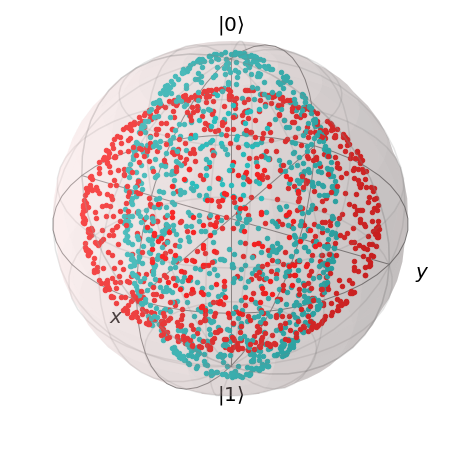

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')
qk.visualization.plot_bloch_vector([0,0,0], ax=ax)
for (x, y, z) in b_vec_with_noise[:1000]:
        ax.scatter3D(y, -x, z, c='c')
for (x,y,z) in blo_vectors_with_noise[:1000]:
        ax.scatter3D(y, -x, z, c='r')

In [57]:
first_slice_value = 4000
last_slice_value = 4500

#Splitting the dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:4000], bloch_vectors_with_noise[first_slice_value:last_slice_value], bloch_vectors_with_noise[last_slice_value:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
x_val = tf.convert_to_tensor(x_val_list)
x_test = tf.convert_to_tensor(x_test_list)

#Defining the labels (Phase Error = 0, Amplitude Damping Error = 1)
y_label_train = [0,1] * int(first_slice_value/2)
y_label_val = [0,1] * int((last_slice_value - first_slice_value)/2)
y_label_test = [0,1] * int((last_slice_value - first_slice_value)/2)

#Convert to tensors
y_train = tf.convert_to_tensor(y_label_train)
y_val = tf.convert_to_tensor(y_label_val)
y_test = tf.convert_to_tensor(y_label_test)

#Define the one-hot vectors
y_train_oh = tf.keras.utils.to_categorical(y_train, 2)
y_val_oh = tf.keras.utils.to_categorical(y_val, 2)
y_test_oh = tf.keras.utils.to_categorical(y_test, 2)

4000
4000


In [58]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dropout(0.1), 
  tf.keras.layers.Dense(64, activation='relu'),  
  tf.keras.layers.Dense(2, activation = 'softmax')
  ])

In [59]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)  
model.compile(loss='categorical_crossentropy',
             optimizer=adam_opt,
             metrics=['accuracy'])

In [60]:
# Train Model
batch_size = 800
epochs = 1000

history = model.fit(x_train, y_train_oh, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val_oh))

Epoch 1/1000
5/5 [==============================] - 1s 57ms/step - loss: 0.6938 - accuracy: 0.4950 - val_loss: 0.6901 - val_accuracy: 0.5460
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6854 - accuracy: 0.5763 - val_loss: 0.6826 - val_accuracy: 0.6000
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6784 - accuracy: 0.6025 - val_loss: 0.6756 - val_accuracy: 0.6020
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6710 - accuracy: 0.6215 - val_loss: 0.6691 - val_accuracy: 0.6120
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6640 - accuracy: 0.6285 - val_loss: 0.6625 - val_accuracy: 0.6180
Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6581 - accuracy: 0.6332 - val_loss: 0.6563 - val_accuracy: 0.6160
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6513 - accuracy: 0.6317 - val_loss: 0.6499 - val_accuracy: 0.6240
Epoch 8/1000


Epoch 59/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.3814 - accuracy: 0.8605 - val_loss: 0.3566 - val_accuracy: 0.8620
Epoch 60/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.3746 - accuracy: 0.8612 - val_loss: 0.3525 - val_accuracy: 0.8660
Epoch 61/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.3728 - accuracy: 0.8635 - val_loss: 0.3493 - val_accuracy: 0.8660
Epoch 62/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.3716 - accuracy: 0.8635 - val_loss: 0.3470 - val_accuracy: 0.8660
Epoch 63/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3661 - accuracy: 0.8643 - val_loss: 0.3434 - val_accuracy: 0.8680
Epoch 64/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.3622 - accuracy: 0.8660 - val_loss: 0.3407 - val_accuracy: 0.8640
Epoch 65/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3656 - accuracy: 0.8633 - val_loss: 0.3373 - val_accuracy: 0.8700
Epoch 

5/5 [==============================] - 0s 14ms/step - loss: 0.1752 - accuracy: 0.9312 - val_loss: 0.1719 - val_accuracy: 0.9400
Epoch 174/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1761 - accuracy: 0.9275 - val_loss: 0.1698 - val_accuracy: 0.9320
Epoch 175/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1697 - accuracy: 0.9325 - val_loss: 0.1697 - val_accuracy: 0.9300
Epoch 176/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1694 - accuracy: 0.9385 - val_loss: 0.1682 - val_accuracy: 0.9280
Epoch 177/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1684 - accuracy: 0.9327 - val_loss: 0.1680 - val_accuracy: 0.9240
Epoch 178/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1679 - accuracy: 0.9342 - val_loss: 0.1642 - val_accuracy: 0.9380
Epoch 179/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1673 - accuracy: 0.9427 - val_loss: 0.1674 - val_accuracy: 0.9240
Epoch 180/1000

5/5 [==============================] - 0s 13ms/step - loss: 0.0984 - accuracy: 0.9675 - val_loss: 0.0990 - val_accuracy: 0.9600
Epoch 288/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0985 - accuracy: 0.9670 - val_loss: 0.0967 - val_accuracy: 0.9660
Epoch 289/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0994 - accuracy: 0.9670 - val_loss: 0.1016 - val_accuracy: 0.9440
Epoch 290/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0996 - accuracy: 0.9675 - val_loss: 0.0977 - val_accuracy: 0.9640
Epoch 291/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0990 - accuracy: 0.9672 - val_loss: 0.0974 - val_accuracy: 0.9600
Epoch 292/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1009 - accuracy: 0.9660 - val_loss: 0.0991 - val_accuracy: 0.9520
Epoch 293/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0988 - accuracy: 0.9640 - val_loss: 0.0963 - val_accuracy: 0.9600
Epoch 294/1000

5/5 [==============================] - 0s 13ms/step - loss: 0.0808 - accuracy: 0.9693 - val_loss: 0.0790 - val_accuracy: 0.9720
Epoch 402/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0793 - accuracy: 0.9712 - val_loss: 0.0822 - val_accuracy: 0.9700
Epoch 403/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0800 - accuracy: 0.9740 - val_loss: 0.0798 - val_accuracy: 0.9700
Epoch 404/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0820 - accuracy: 0.9693 - val_loss: 0.0794 - val_accuracy: 0.9720
Epoch 405/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0771 - accuracy: 0.9740 - val_loss: 0.0797 - val_accuracy: 0.9700
Epoch 406/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0770 - accuracy: 0.9735 - val_loss: 0.0876 - val_accuracy: 0.9500
Epoch 407/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0758 - accuracy: 0.9735 - val_loss: 0.0789 - val_accuracy: 0.9720
Epoch 408/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 0.0756 - val_accuracy: 0.9680
Epoch 516/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0692 - accuracy: 0.9755 - val_loss: 0.0738 - val_accuracy: 0.9680
Epoch 517/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0667 - accuracy: 0.9772 - val_loss: 0.0747 - val_accuracy: 0.9680
Epoch 518/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0687 - accuracy: 0.9768 - val_loss: 0.0711 - val_accuracy: 0.9740
Epoch 519/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0680 - accuracy: 0.9770 - val_loss: 0.0715 - val_accuracy: 0.9800
Epoch 520/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0703 - accuracy: 0.9783 - val_loss: 0.0773 - val_accuracy: 0.9640
Epoch 521/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0670 - accuracy: 0.9765 - val_loss: 0.0701 - val_accuracy: 0.9840
Epoch 522/1000

5/5 [==============================] - 0s 13ms/step - loss: 0.0594 - accuracy: 0.9797 - val_loss: 0.0685 - val_accuracy: 0.9760
Epoch 630/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0610 - accuracy: 0.9785 - val_loss: 0.0671 - val_accuracy: 0.9780
Epoch 631/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0595 - accuracy: 0.9797 - val_loss: 0.0726 - val_accuracy: 0.9660
Epoch 632/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0645 - accuracy: 0.9760 - val_loss: 0.0662 - val_accuracy: 0.9740
Epoch 633/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0592 - accuracy: 0.9808 - val_loss: 0.0690 - val_accuracy: 0.9700
Epoch 634/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0633 - accuracy: 0.9768 - val_loss: 0.0694 - val_accuracy: 0.9660
Epoch 635/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0578 - accuracy: 0.9800 - val_loss: 0.0655 - val_accuracy: 0.9840
Epoch 636/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.0540 - accuracy: 0.9797 - val_loss: 0.0640 - val_accuracy: 0.9740
Epoch 744/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.9800 - val_loss: 0.0648 - val_accuracy: 0.9760
Epoch 745/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0538 - accuracy: 0.9810 - val_loss: 0.0638 - val_accuracy: 0.9800
Epoch 746/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0558 - accuracy: 0.9783 - val_loss: 0.0627 - val_accuracy: 0.9780
Epoch 747/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0557 - accuracy: 0.9822 - val_loss: 0.0635 - val_accuracy: 0.9780
Epoch 748/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0558 - accuracy: 0.9778 - val_loss: 0.0677 - val_accuracy: 0.9640
Epoch 749/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0531 - accuracy: 0.9797 - val_loss: 0.0616 - val_accuracy: 0.9760
Epoch 750/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.0538 - accuracy: 0.9815 - val_loss: 0.0615 - val_accuracy: 0.9680
Epoch 858/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0540 - accuracy: 0.9815 - val_loss: 0.0655 - val_accuracy: 0.9680
Epoch 859/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0551 - accuracy: 0.9785 - val_loss: 0.0615 - val_accuracy: 0.9740
Epoch 860/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0550 - accuracy: 0.9818 - val_loss: 0.0627 - val_accuracy: 0.9720
Epoch 861/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0515 - accuracy: 0.9812 - val_loss: 0.0635 - val_accuracy: 0.9720
Epoch 862/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0535 - accuracy: 0.9800 - val_loss: 0.0619 - val_accuracy: 0.9760
Epoch 863/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0516 - accuracy: 0.9815 - val_loss: 0.0636 - val_accuracy: 0.9720
Epoch 864/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.0503 - accuracy: 0.9830 - val_loss: 0.0598 - val_accuracy: 0.9740
Epoch 972/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0484 - accuracy: 0.9833 - val_loss: 0.0605 - val_accuracy: 0.9760
Epoch 973/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.0649 - val_accuracy: 0.9720
Epoch 974/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0549 - accuracy: 0.9783 - val_loss: 0.0600 - val_accuracy: 0.9760
Epoch 975/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0511 - accuracy: 0.9800 - val_loss: 0.0598 - val_accuracy: 0.9720
Epoch 976/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0475 - accuracy: 0.9845 - val_loss: 0.0633 - val_accuracy: 0.9740
Epoch 977/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0485 - accuracy: 0.9825 - val_loss: 0.0653 - val_accuracy: 0.9700
Epoch 978/1000

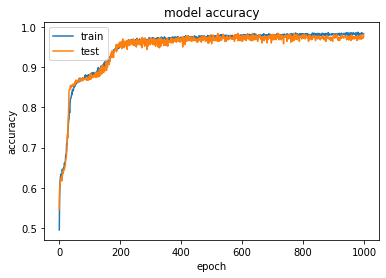

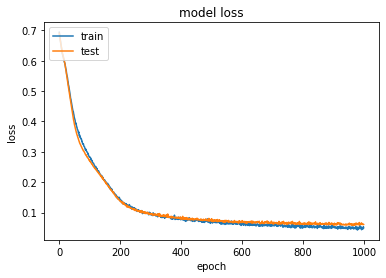

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test_oh, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9860000014305115


In [63]:
y_tilde = model.predict(x_test)
for i in range(len(x_test)):
  print(i, "Prediction: {}, True label: {}".format(y_tilde[i], y_test[i]))

16/16 [==============================] - 0s 2ms/step
0 Prediction: [1.000000e+00 7.970947e-12], True label: 0
1 Prediction: [0.35937816 0.6406218 ], True label: 1
2 Prediction: [1.000000e+00 6.287267e-10], True label: 0
3 Prediction: [2.7856599e-05 9.9997211e-01], True label: 1
4 Prediction: [9.9999070e-01 9.3340095e-06], True label: 0
5 Prediction: [0.01541896 0.98458105], True label: 1
6 Prediction: [0.5986439  0.40135604], True label: 0
7 Prediction: [8.910016e-22 1.000000e+00], True label: 1
8 Prediction: [0.99045396 0.00954612], True label: 0
9 Prediction: [0.00406775 0.9959323 ], True label: 1
10 Prediction: [9.9989331e-01 1.0668686e-04], True label: 0
11 Prediction: [3.1372372e-05 9.9996865e-01], True label: 1
12 Prediction: [1.0000000e+00 1.1381892e-11], True label: 0
13 Prediction: [3.2920686e-24 1.0000000e+00], True label: 1
14 Prediction: [9.9999940e-01 5.3724784e-07], True label: 0
15 Prediction: [0.05237222 0.94762784], True label: 1
16 Prediction: [1.0000000e+00 2.7397158

147 Prediction: [8.1476837e-04 9.9918526e-01], True label: 1
148 Prediction: [1.0000000e+00 1.2941934e-10], True label: 0
149 Prediction: [4.803672e-17 1.000000e+00], True label: 1
150 Prediction: [1.0000000e+00 4.8082337e-11], True label: 0
151 Prediction: [0.01038177 0.98961824], True label: 1
152 Prediction: [9.9999952e-01 4.7600702e-07], True label: 0
153 Prediction: [4.4474828e-26 1.0000000e+00], True label: 1
154 Prediction: [9.999894e-01 1.058625e-05], True label: 0
155 Prediction: [0.02073873 0.97926134], True label: 1
156 Prediction: [0.95792854 0.04207146], True label: 0
157 Prediction: [6.399983e-10 1.000000e+00], True label: 1
158 Prediction: [9.999999e-01 8.899175e-08], True label: 0
159 Prediction: [4.9264866e-25 1.0000000e+00], True label: 1
160 Prediction: [9.9999833e-01 1.7059619e-06], True label: 0
161 Prediction: [3.6368342e-25 1.0000000e+00], True label: 1
162 Prediction: [0.9987538  0.00124616], True label: 0
163 Prediction: [6.934403e-26 1.000000e+00], True label:

352 Prediction: [9.9998319e-01 1.6790422e-05], True label: 0
353 Prediction: [0.00553085 0.99446917], True label: 1
354 Prediction: [1.000000e+00 2.992728e-12], True label: 0
355 Prediction: [2.2291816e-25 1.0000000e+00], True label: 1
356 Prediction: [0.47404486 0.52595514], True label: 0
357 Prediction: [7.394628e-18 1.000000e+00], True label: 1
358 Prediction: [9.999999e-01 1.549893e-07], True label: 0
359 Prediction: [6.0457545e-19 1.0000000e+00], True label: 1
360 Prediction: [9.9999785e-01 2.1901089e-06], True label: 0
361 Prediction: [0.00206032 0.99793965], True label: 1
362 Prediction: [0.9298981  0.07010192], True label: 0
363 Prediction: [7.30047e-21 1.00000e+00], True label: 1
364 Prediction: [0.8886503 0.1113497], True label: 0
365 Prediction: [8.531561e-22 1.000000e+00], True label: 1
366 Prediction: [9.9999428e-01 5.7097373e-06], True label: 0
367 Prediction: [1.2462754e-19 1.0000000e+00], True label: 1
368 Prediction: [9.9999857e-01 1.4810468e-06], True label: 0
369 Pre

## Phase flip, Depolarizing and Amplitude damping errors

In [64]:
num_samples = 1200
data = generate_Haar_data(1, num_samples)

In [65]:
density_matrix_noise_free = [*map(get_density_matrix, data)]
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

In [66]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(400):
   single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
   density_matrix_with_noise.append(single_data_with_noise)

for i in range(400, 800):
   single_data_with_noise = depolar_error(1, density_matrix_noise_free[i], 0.2)
   density_matrix_with_noise.append(single_data_with_noise)

for i in range(800, num_samples):
    single_data_with_noise = ampl_damp_error(1, density_matrix_noise_free[i], 0.5, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)

bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

complete_vectors = []
for i in range(num_samples):
   element = np.concatenate((bloch_vectors_with_noise[i], bloch_vectors_noise_free[i]))
   complete_vectors.append(element)

for i in range(400):
  complete_vectors[i] = np.append(complete_vectors[i], 0) #phase flip error

for i in range(400, 800):
  complete_vectors[i] = np.append(complete_vectors[i], 1) #depolarizing error

for i in range(800, num_samples):
  complete_vectors[i] = np.append(complete_vectors[i], 2)  #amplitude damping error

random.shuffle(complete_vectors)
print(complete_vectors[3])

[-0.01840429 -0.34717002 -0.8150226  -0.03067381 -0.5786167  -0.8150226
  0.        ]


In [67]:
#Building the dataset

x_dataset = []

for item in complete_vectors:
  element = item[:-1]
  x_dataset.append(element)

#print(x_dataset)

y_dataset = []
for item in complete_vectors:
  element = item[-1:]
  y_dataset.append(element)

#print(y_dataset)

first_slice_value = 960
last_slice_value = 1080

#Splitting the dataset
x_train_list, x_val_list, x_test_list = x_dataset[:first_slice_value], x_dataset[first_slice_value:last_slice_value], x_dataset[last_slice_value:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
x_val = tf.convert_to_tensor(x_val_list)
x_test = tf.convert_to_tensor(x_test_list)

#Defining the labels 
y_label_train, y_label_val, y_label_test = y_dataset[:first_slice_value], y_dataset[first_slice_value:last_slice_value], y_dataset[last_slice_value:]

#Convert to tensors
y_train = tf.convert_to_tensor(y_label_train)
y_val = tf.convert_to_tensor(y_label_val)
y_test = tf.convert_to_tensor(y_label_test)

#Define the one-hot vectors
y_train_oh = tf.keras.utils.to_categorical(y_train, 3)
y_val_oh = tf.keras.utils.to_categorical(y_val, 3)
y_test_oh = tf.keras.utils.to_categorical(y_test, 3)

In [68]:
# Define Model
model = tf.keras.models.Sequential([  
  tf.keras.layers.InputLayer(input_shape=(6,)),              
  tf.keras.layers.Dense(128, activation='relu'),  
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(3, activation = 'softmax')
  ])

In [69]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0005)
model.compile(loss='categorical_crossentropy',
             optimizer=adam_opt,
             metrics=['accuracy'])

In [70]:
#Train Model
batch_size = 240
epochs = 1500 #with 300 epochs we can notice the difference between phase error and the other two

history = model.fit(x_train,
         y_train_oh,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_val, y_val_oh))

Epoch 1/1500
4/4 [==============================] - 1s 75ms/step - loss: 1.0969 - accuracy: 0.3479 - val_loss: 1.1062 - val_accuracy: 0.2250
Epoch 2/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0902 - accuracy: 0.3594 - val_loss: 1.1039 - val_accuracy: 0.2500
Epoch 3/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0851 - accuracy: 0.3802 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 4/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0806 - accuracy: 0.3938 - val_loss: 1.0951 - val_accuracy: 0.3500
Epoch 5/1500
4/4 [==============================] - 0s 15ms/step - loss: 1.0762 - accuracy: 0.4146 - val_loss: 1.0917 - val_accuracy: 0.3667
Epoch 6/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0724 - accuracy: 0.4156 - val_loss: 1.0896 - val_accuracy: 0.3917
Epoch 7/1500
4/4 [==============================] - 0s 18ms/step - loss: 1.0680 - accuracy: 0.4281 - val_loss: 1.0869 - val_accuracy: 0.3750
Epoch 8/1500


Epoch 59/1500
4/4 [==============================] - 0s 17ms/step - loss: 0.2553 - accuracy: 0.9448 - val_loss: 0.2930 - val_accuracy: 0.9333
Epoch 60/1500
4/4 [==============================] - 0s 18ms/step - loss: 0.2478 - accuracy: 0.9760 - val_loss: 0.2761 - val_accuracy: 0.9583
Epoch 61/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.2435 - accuracy: 0.9698 - val_loss: 0.2786 - val_accuracy: 0.9167
Epoch 62/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.2302 - accuracy: 0.9740 - val_loss: 0.2481 - val_accuracy: 0.9917
Epoch 63/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.2273 - accuracy: 0.9875 - val_loss: 0.2612 - val_accuracy: 0.9500
Epoch 64/1500
4/4 [==============================] - 0s 21ms/step - loss: 0.2175 - accuracy: 0.9698 - val_loss: 0.2288 - val_accuracy: 0.9750
Epoch 65/1500
4/4 [==============================] - 0s 18ms/step - loss: 0.2121 - accuracy: 0.9792 - val_loss: 0.2427 - val_accuracy: 1.0000
Epoch 

4/4 [==============================] - 0s 17ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 174/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 175/1500
4/4 [==============================] - 0s 21ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 176/1500
4/4 [==============================] - 0s 17ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 177/1500
4/4 [==============================] - 0s 18ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 178/1500
4/4 [==============================] - 0s 18ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 179/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 180/1500

4/4 [==============================] - 0s 16ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 288/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 289/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 290/1500
4/4 [==============================] - 0s 17ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 291/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 292/1500
4/4 [==============================] - 0s 17ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 293/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 294/1500

4/4 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 402/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 403/1500
4/4 [==============================] - 0s 18ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 404/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 405/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 406/1500
4/4 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 407/1500
4/4 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 408/1500

Epoch 515/1500
4/4 [==============================] - 0s 14ms/step - loss: 8.8198e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 516/1500
4/4 [==============================] - 0s 15ms/step - loss: 8.8287e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 517/1500
4/4 [==============================] - 0s 16ms/step - loss: 8.7154e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 518/1500
4/4 [==============================] - 0s 15ms/step - loss: 8.6882e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 519/1500
4/4 [==============================] - 0s 14ms/step - loss: 8.6872e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 520/1500
4/4 [==============================] - 0s 15ms/step - loss: 8.6706e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 521/1500
4/4 [==============================] - 0s 14ms/step - loss: 8.5916e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 571/1500
4/4 [==============================] - 0s 15ms/step - loss: 6.7959e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 572/1500
4/4 [==============================] - 0s 16ms/step - loss: 6.7627e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 573/1500
4/4 [==============================] - 0s 14ms/step - loss: 6.6162e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 574/1500
4/4 [==============================] - 0s 14ms/step - loss: 6.6246e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 575/1500
4/4 [==============================] - 0s 15ms/step - loss: 6.5988e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 576/1500
4/4 [==============================] - 0s 15ms/step - loss: 6.5656e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 577/1500
4/4 [==============================] - 0s 15ms/step - loss: 6.5464e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 627/1500
4/4 [==============================] - 0s 14ms/step - loss: 5.2750e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 628/1500
4/4 [==============================] - 0s 16ms/step - loss: 5.2367e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 629/1500
4/4 [==============================] - 0s 17ms/step - loss: 5.2667e-04 - accuracy: 1.0000 - val_loss: 9.9255e-04 - val_accuracy: 1.0000
Epoch 630/1500
4/4 [==============================] - 0s 14ms/step - loss: 5.1641e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 631/1500
4/4 [==============================] - 0s 14ms/step - loss: 5.1144e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 632/1500
4/4 [==============================] - 0s 14ms/step - loss: 5.1183e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 633/1500
4/4 [==============================] - 0s 14ms/step - loss: 5.0859e-04 - accuracy: 1.0000 - val_los

4/4 [==============================] - 0s 14ms/step - loss: 3.3764e-04 - accuracy: 1.0000 - val_loss: 7.2350e-04 - val_accuracy: 1.0000
Epoch 736/1500
4/4 [==============================] - 0s 15ms/step - loss: 3.3781e-04 - accuracy: 1.0000 - val_loss: 6.8096e-04 - val_accuracy: 1.0000
Epoch 737/1500
4/4 [==============================] - 0s 14ms/step - loss: 3.3404e-04 - accuracy: 1.0000 - val_loss: 6.9943e-04 - val_accuracy: 1.0000
Epoch 738/1500
4/4 [==============================] - 0s 13ms/step - loss: 3.3608e-04 - accuracy: 1.0000 - val_loss: 7.4660e-04 - val_accuracy: 1.0000
Epoch 739/1500
4/4 [==============================] - 0s 14ms/step - loss: 3.3486e-04 - accuracy: 1.0000 - val_loss: 6.6518e-04 - val_accuracy: 1.0000
Epoch 740/1500
4/4 [==============================] - 0s 15ms/step - loss: 3.3222e-04 - accuracy: 1.0000 - val_loss: 7.2072e-04 - val_accuracy: 1.0000
Epoch 741/1500
4/4 [==============================] - 0s 14ms/step - loss: 3.2873e-04 - accuracy: 1.0000 - va

4/4 [==============================] - 0s 16ms/step - loss: 2.2531e-04 - accuracy: 1.0000 - val_loss: 5.1942e-04 - val_accuracy: 1.0000
Epoch 844/1500
4/4 [==============================] - 0s 25ms/step - loss: 2.2532e-04 - accuracy: 1.0000 - val_loss: 5.2011e-04 - val_accuracy: 1.0000
Epoch 845/1500
4/4 [==============================] - 0s 20ms/step - loss: 2.2435e-04 - accuracy: 1.0000 - val_loss: 4.9584e-04 - val_accuracy: 1.0000
Epoch 846/1500
4/4 [==============================] - 0s 22ms/step - loss: 2.2469e-04 - accuracy: 1.0000 - val_loss: 5.0855e-04 - val_accuracy: 1.0000
Epoch 847/1500
4/4 [==============================] - 0s 24ms/step - loss: 2.2405e-04 - accuracy: 1.0000 - val_loss: 4.9666e-04 - val_accuracy: 1.0000
Epoch 848/1500
4/4 [==============================] - 0s 34ms/step - loss: 2.2379e-04 - accuracy: 1.0000 - val_loss: 4.9322e-04 - val_accuracy: 1.0000
Epoch 849/1500
4/4 [==============================] - 0s 23ms/step - loss: 2.2092e-04 - accuracy: 1.0000 - va

4/4 [==============================] - 0s 26ms/step - loss: 1.5891e-04 - accuracy: 1.0000 - val_loss: 3.9322e-04 - val_accuracy: 1.0000
Epoch 952/1500
4/4 [==============================] - 0s 22ms/step - loss: 1.5735e-04 - accuracy: 1.0000 - val_loss: 3.6476e-04 - val_accuracy: 1.0000
Epoch 953/1500
4/4 [==============================] - 0s 28ms/step - loss: 1.5747e-04 - accuracy: 1.0000 - val_loss: 3.6661e-04 - val_accuracy: 1.0000
Epoch 954/1500
4/4 [==============================] - 0s 23ms/step - loss: 1.5499e-04 - accuracy: 1.0000 - val_loss: 3.8940e-04 - val_accuracy: 1.0000
Epoch 955/1500
4/4 [==============================] - 0s 20ms/step - loss: 1.5581e-04 - accuracy: 1.0000 - val_loss: 3.8302e-04 - val_accuracy: 1.0000
Epoch 956/1500
4/4 [==============================] - 0s 29ms/step - loss: 1.5377e-04 - accuracy: 1.0000 - val_loss: 3.5955e-04 - val_accuracy: 1.0000
Epoch 957/1500
4/4 [==============================] - 0s 29ms/step - loss: 1.5423e-04 - accuracy: 1.0000 - va

4/4 [==============================] - 0s 19ms/step - loss: 1.1153e-04 - accuracy: 1.0000 - val_loss: 2.6895e-04 - val_accuracy: 1.0000
Epoch 1060/1500
4/4 [==============================] - 0s 26ms/step - loss: 1.1160e-04 - accuracy: 1.0000 - val_loss: 2.7378e-04 - val_accuracy: 1.0000
Epoch 1061/1500
4/4 [==============================] - 0s 27ms/step - loss: 1.1263e-04 - accuracy: 1.0000 - val_loss: 3.0696e-04 - val_accuracy: 1.0000
Epoch 1062/1500
4/4 [==============================] - 0s 19ms/step - loss: 1.1137e-04 - accuracy: 1.0000 - val_loss: 2.6660e-04 - val_accuracy: 1.0000
Epoch 1063/1500
4/4 [==============================] - 0s 35ms/step - loss: 1.1092e-04 - accuracy: 1.0000 - val_loss: 2.7191e-04 - val_accuracy: 1.0000
Epoch 1064/1500
4/4 [==============================] - 0s 26ms/step - loss: 1.0961e-04 - accuracy: 1.0000 - val_loss: 2.9011e-04 - val_accuracy: 1.0000
Epoch 1065/1500
4/4 [==============================] - 0s 19ms/step - loss: 1.0930e-04 - accuracy: 1.000

4/4 [==============================] - 0s 20ms/step - loss: 9.5085e-05 - accuracy: 1.0000 - val_loss: 2.3882e-04 - val_accuracy: 1.0000
Epoch 1114/1500
4/4 [==============================] - 0s 20ms/step - loss: 9.5035e-05 - accuracy: 1.0000 - val_loss: 2.3989e-04 - val_accuracy: 1.0000
Epoch 1115/1500
4/4 [==============================] - 0s 22ms/step - loss: 9.4851e-05 - accuracy: 1.0000 - val_loss: 2.4769e-04 - val_accuracy: 1.0000
Epoch 1116/1500
4/4 [==============================] - 0s 17ms/step - loss: 9.4000e-05 - accuracy: 1.0000 - val_loss: 2.5362e-04 - val_accuracy: 1.0000
Epoch 1117/1500
4/4 [==============================] - 0s 26ms/step - loss: 9.4495e-05 - accuracy: 1.0000 - val_loss: 2.4560e-04 - val_accuracy: 1.0000
Epoch 1118/1500
4/4 [==============================] - 0s 23ms/step - loss: 9.3358e-05 - accuracy: 1.0000 - val_loss: 2.3384e-04 - val_accuracy: 1.0000
Epoch 1119/1500
4/4 [==============================] - 0s 20ms/step - loss: 9.2784e-05 - accuracy: 1.000

4/4 [==============================] - 0s 23ms/step - loss: 8.1260e-05 - accuracy: 1.0000 - val_loss: 2.2485e-04 - val_accuracy: 1.0000
Epoch 1168/1500
4/4 [==============================] - 0s 25ms/step - loss: 8.1362e-05 - accuracy: 1.0000 - val_loss: 2.1438e-04 - val_accuracy: 1.0000
Epoch 1169/1500
4/4 [==============================] - 0s 23ms/step - loss: 8.1001e-05 - accuracy: 1.0000 - val_loss: 2.0153e-04 - val_accuracy: 1.0000
Epoch 1170/1500
4/4 [==============================] - 0s 19ms/step - loss: 8.0248e-05 - accuracy: 1.0000 - val_loss: 2.0753e-04 - val_accuracy: 1.0000
Epoch 1171/1500
4/4 [==============================] - 0s 23ms/step - loss: 7.9950e-05 - accuracy: 1.0000 - val_loss: 2.1698e-04 - val_accuracy: 1.0000
Epoch 1172/1500
4/4 [==============================] - 0s 26ms/step - loss: 8.0270e-05 - accuracy: 1.0000 - val_loss: 2.1557e-04 - val_accuracy: 1.0000
Epoch 1173/1500
4/4 [==============================] - 0s 21ms/step - loss: 7.9741e-05 - accuracy: 1.000

4/4 [==============================] - 0s 25ms/step - loss: 6.8863e-05 - accuracy: 1.0000 - val_loss: 1.8401e-04 - val_accuracy: 1.0000
Epoch 1222/1500
4/4 [==============================] - 0s 18ms/step - loss: 6.9148e-05 - accuracy: 1.0000 - val_loss: 1.9300e-04 - val_accuracy: 1.0000
Epoch 1223/1500
4/4 [==============================] - 0s 27ms/step - loss: 6.8610e-05 - accuracy: 1.0000 - val_loss: 1.8410e-04 - val_accuracy: 1.0000
Epoch 1224/1500
4/4 [==============================] - 0s 22ms/step - loss: 6.8969e-05 - accuracy: 1.0000 - val_loss: 1.8375e-04 - val_accuracy: 1.0000
Epoch 1225/1500
4/4 [==============================] - 0s 23ms/step - loss: 6.8263e-05 - accuracy: 1.0000 - val_loss: 1.8572e-04 - val_accuracy: 1.0000
Epoch 1226/1500
4/4 [==============================] - 0s 24ms/step - loss: 6.8142e-05 - accuracy: 1.0000 - val_loss: 1.8498e-04 - val_accuracy: 1.0000
Epoch 1227/1500
4/4 [==============================] - 0s 24ms/step - loss: 6.8407e-05 - accuracy: 1.000

4/4 [==============================] - 0s 20ms/step - loss: 5.9400e-05 - accuracy: 1.0000 - val_loss: 1.6613e-04 - val_accuracy: 1.0000
Epoch 1276/1500
4/4 [==============================] - 0s 19ms/step - loss: 5.9180e-05 - accuracy: 1.0000 - val_loss: 1.6044e-04 - val_accuracy: 1.0000
Epoch 1277/1500
4/4 [==============================] - 0s 22ms/step - loss: 5.9204e-05 - accuracy: 1.0000 - val_loss: 1.6061e-04 - val_accuracy: 1.0000
Epoch 1278/1500
4/4 [==============================] - 0s 21ms/step - loss: 5.9064e-05 - accuracy: 1.0000 - val_loss: 1.7198e-04 - val_accuracy: 1.0000
Epoch 1279/1500
4/4 [==============================] - 0s 24ms/step - loss: 5.8817e-05 - accuracy: 1.0000 - val_loss: 1.6598e-04 - val_accuracy: 1.0000
Epoch 1280/1500
4/4 [==============================] - 0s 21ms/step - loss: 5.8745e-05 - accuracy: 1.0000 - val_loss: 1.5371e-04 - val_accuracy: 1.0000
Epoch 1281/1500
4/4 [==============================] - 0s 30ms/step - loss: 5.8510e-05 - accuracy: 1.000

4/4 [==============================] - 0s 23ms/step - loss: 5.1487e-05 - accuracy: 1.0000 - val_loss: 1.4797e-04 - val_accuracy: 1.0000
Epoch 1330/1500
4/4 [==============================] - 0s 23ms/step - loss: 5.0831e-05 - accuracy: 1.0000 - val_loss: 1.4359e-04 - val_accuracy: 1.0000
Epoch 1331/1500
4/4 [==============================] - 0s 17ms/step - loss: 5.0928e-05 - accuracy: 1.0000 - val_loss: 1.4128e-04 - val_accuracy: 1.0000
Epoch 1332/1500
4/4 [==============================] - 0s 28ms/step - loss: 5.0692e-05 - accuracy: 1.0000 - val_loss: 1.4780e-04 - val_accuracy: 1.0000
Epoch 1333/1500
4/4 [==============================] - 0s 30ms/step - loss: 5.0711e-05 - accuracy: 1.0000 - val_loss: 1.4526e-04 - val_accuracy: 1.0000
Epoch 1334/1500
4/4 [==============================] - 0s 19ms/step - loss: 5.0917e-05 - accuracy: 1.0000 - val_loss: 1.3747e-04 - val_accuracy: 1.0000
Epoch 1335/1500
4/4 [==============================] - 0s 25ms/step - loss: 5.0438e-05 - accuracy: 1.000

4/4 [==============================] - 0s 23ms/step - loss: 4.4143e-05 - accuracy: 1.0000 - val_loss: 1.2837e-04 - val_accuracy: 1.0000
Epoch 1384/1500
4/4 [==============================] - 0s 17ms/step - loss: 4.3974e-05 - accuracy: 1.0000 - val_loss: 1.3096e-04 - val_accuracy: 1.0000
Epoch 1385/1500
4/4 [==============================] - 0s 23ms/step - loss: 4.4332e-05 - accuracy: 1.0000 - val_loss: 1.3395e-04 - val_accuracy: 1.0000
Epoch 1386/1500
4/4 [==============================] - 0s 22ms/step - loss: 4.3770e-05 - accuracy: 1.0000 - val_loss: 1.2306e-04 - val_accuracy: 1.0000
Epoch 1387/1500
4/4 [==============================] - 0s 22ms/step - loss: 4.3831e-05 - accuracy: 1.0000 - val_loss: 1.2692e-04 - val_accuracy: 1.0000
Epoch 1388/1500
4/4 [==============================] - 0s 21ms/step - loss: 4.3584e-05 - accuracy: 1.0000 - val_loss: 1.2813e-04 - val_accuracy: 1.0000
Epoch 1389/1500
4/4 [==============================] - 0s 23ms/step - loss: 4.3191e-05 - accuracy: 1.000

4/4 [==============================] - 0s 25ms/step - loss: 3.8567e-05 - accuracy: 1.0000 - val_loss: 1.1772e-04 - val_accuracy: 1.0000
Epoch 1438/1500
4/4 [==============================] - 0s 19ms/step - loss: 3.8049e-05 - accuracy: 1.0000 - val_loss: 1.1312e-04 - val_accuracy: 1.0000
Epoch 1439/1500
4/4 [==============================] - 0s 25ms/step - loss: 3.8033e-05 - accuracy: 1.0000 - val_loss: 1.0837e-04 - val_accuracy: 1.0000
Epoch 1440/1500
4/4 [==============================] - 0s 25ms/step - loss: 3.7896e-05 - accuracy: 1.0000 - val_loss: 1.1109e-04 - val_accuracy: 1.0000
Epoch 1441/1500
4/4 [==============================] - 0s 24ms/step - loss: 3.7747e-05 - accuracy: 1.0000 - val_loss: 1.1932e-04 - val_accuracy: 1.0000
Epoch 1442/1500
4/4 [==============================] - 0s 23ms/step - loss: 3.7983e-05 - accuracy: 1.0000 - val_loss: 1.1392e-04 - val_accuracy: 1.0000
Epoch 1443/1500
4/4 [==============================] - 0s 23ms/step - loss: 3.7327e-05 - accuracy: 1.000

4/4 [==============================] - 0s 24ms/step - loss: 3.3126e-05 - accuracy: 1.0000 - val_loss: 9.8745e-05 - val_accuracy: 1.0000
Epoch 1492/1500
4/4 [==============================] - 0s 17ms/step - loss: 3.2859e-05 - accuracy: 1.0000 - val_loss: 9.9387e-05 - val_accuracy: 1.0000
Epoch 1493/1500
4/4 [==============================] - 0s 21ms/step - loss: 3.2789e-05 - accuracy: 1.0000 - val_loss: 1.0084e-04 - val_accuracy: 1.0000
Epoch 1494/1500
4/4 [==============================] - 0s 19ms/step - loss: 3.2727e-05 - accuracy: 1.0000 - val_loss: 9.9727e-05 - val_accuracy: 1.0000
Epoch 1495/1500
4/4 [==============================] - 0s 21ms/step - loss: 3.2574e-05 - accuracy: 1.0000 - val_loss: 1.0074e-04 - val_accuracy: 1.0000
Epoch 1496/1500
4/4 [==============================] - 0s 20ms/step - loss: 3.2631e-05 - accuracy: 1.0000 - val_loss: 1.0069e-04 - val_accuracy: 1.0000
Epoch 1497/1500
4/4 [==============================] - 0s 27ms/step - loss: 3.2550e-05 - accuracy: 1.000

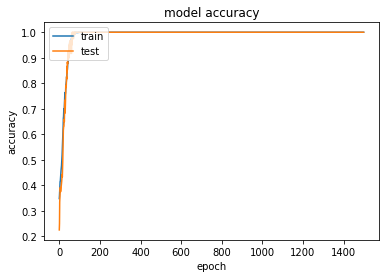

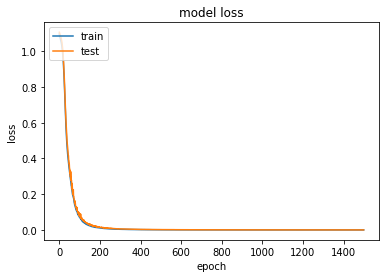

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test_oh, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [73]:
y_tilde = model.predict(x_test)
for i in range(len(x_test)):
  print(i, "Prediction: {}, True label: {}".format(y_tilde[i], y_test[i]))

4/4 [==============================] - 0s 5ms/step
0 Prediction: [9.9999809e-01 1.8961375e-06 2.5111310e-36], True label: [0.]
1 Prediction: [2.6017806e-11 1.5429656e-04 9.9984562e-01], True label: [2.]
2 Prediction: [9.9999392e-01 6.1270657e-06 2.4094104e-35], True label: [0.]
3 Prediction: [9.9999964e-01 3.3544026e-07 1.4551292e-38], True label: [0.]
4 Prediction: [1.9127361e-10 4.7743705e-04 9.9952257e-01], True label: [2.]
5 Prediction: [9.9999893e-01 1.0378003e-06 0.0000000e+00], True label: [0.]
6 Prediction: [2.2030580e-12 3.0116018e-05 9.9996984e-01], True label: [2.]
7 Prediction: [9.9999702e-01 2.9355492e-06 7.3963930e-38], True label: [0.]
8 Prediction: [3.1711355e-13 2.0912580e-06 9.9999785e-01], True label: [2.]
9 Prediction: [6.8210147e-07 9.9999642e-01 2.9092075e-06], True label: [1.]
10 Prediction: [7.9190920e-07 9.9999857e-01 6.0339522e-07], True label: [1.]
11 Prediction: [3.4696320e-16 2.0766471e-08 1.0000000e+00], True label: [2.]
12 Prediction: [9.9999440e-01 5.575

116 Prediction: [5.94678430e-12 1.06719735e-05 9.99989271e-01], True label: [2.]
117 Prediction: [2.9283333e-13 3.8027358e-06 9.9999619e-01], True label: [2.]
118 Prediction: [9.9999809e-01 1.9486968e-06 5.0070710e-34], True label: [0.]
119 Prediction: [9.9999809e-01 1.9158449e-06 3.1310954e-36], True label: [0.]


## Bit flip, Phase flip and Bit-phase flip errors

In [75]:
num_samples = 1200
data = generate_Haar_data(1, num_samples)

In [76]:
density_matrix_noise_free = [*map(get_density_matrix, data)]
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

In [77]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(400):
   single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'bit', 0.1)
   density_matrix_with_noise.append(single_data_with_noise)

for i in range(400, 800):
   single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
   density_matrix_with_noise.append(single_data_with_noise)

for i in range(800, num_samples):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'bp', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

complete_vectors = []
for i in range(num_samples):
   element = np.concatenate((bloch_vectors_with_noise[i], bloch_vectors_noise_free[i]))
   complete_vectors.append(element)

for i in range(400):
  complete_vectors[i] = np.append(complete_vectors[i], 0) #bit flip error

for i in range(400, 800):
  complete_vectors[i] = np.append(complete_vectors[i], 1) #phase error

for i in range(800, num_samples):
  complete_vectors[i] = np.append(complete_vectors[i], 2)  #bit-phase error

random.shuffle(complete_vectors)
print(complete_vectors[3])

[-0.57666822 -0.61171575  0.23016134 -0.57666822 -0.76464469  0.28770168
  0.        ]


In [78]:
#Building the dataset

x_dataset = []

for item in complete_vectors:
  element = item[:-1]
  x_dataset.append(element)

#print(x_dataset)

y_dataset = []
for item in complete_vectors:
  element = item[-1:]
  y_dataset.append(element)

#print(y_dataset)

first_slice_value = 960
last_slice_value = 1080

#Splitting the dataset
x_train_list, x_val_list, x_test_list = x_dataset[:first_slice_value], x_dataset[first_slice_value:last_slice_value], x_dataset[last_slice_value:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
x_val = tf.convert_to_tensor(x_val_list)
x_test = tf.convert_to_tensor(x_test_list)

#Defining the labels 
y_label_train, y_label_val, y_label_test = y_dataset[:first_slice_value], y_dataset[first_slice_value:last_slice_value], y_dataset[last_slice_value:]

#Convert to tensors
y_train = tf.convert_to_tensor(y_label_train)
y_val = tf.convert_to_tensor(y_label_val)
y_test = tf.convert_to_tensor(y_label_test)

#Define the one-hot vectors
y_train_oh = tf.keras.utils.to_categorical(y_train, 3)
y_val_oh = tf.keras.utils.to_categorical(y_val, 3)
y_test_oh = tf.keras.utils.to_categorical(y_test, 3)

### Training the network

In [79]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),   
  tf.keras.layers.Dense(3, activation = 'softmax')
  ])

In [80]:
# Compile model
adam_opt = tf.optimizers.Adam(0.00007)
model.compile(loss='categorical_crossentropy',
             optimizer=adam_opt,
             metrics=['accuracy'])

In [81]:
#Train Model
batch_size = 240
epochs = 5000 

history = model.fit(x_train,
         y_train_oh,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_val, y_val_oh))

Epoch 1/5000
4/4 [==============================] - 2s 151ms/step - loss: 1.1055 - accuracy: 0.3135 - val_loss: 1.1001 - val_accuracy: 0.3417
Epoch 2/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.1035 - accuracy: 0.3271 - val_loss: 1.0998 - val_accuracy: 0.3167
Epoch 3/5000
4/4 [==============================] - 0s 26ms/step - loss: 1.1016 - accuracy: 0.3219 - val_loss: 1.0994 - val_accuracy: 0.3250
Epoch 4/5000
4/4 [==============================] - 0s 23ms/step - loss: 1.0998 - accuracy: 0.3250 - val_loss: 1.0990 - val_accuracy: 0.3500
Epoch 5/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.0982 - accuracy: 0.3313 - val_loss: 1.0986 - val_accuracy: 0.3500
Epoch 6/5000
4/4 [==============================] - 0s 27ms/step - loss: 1.0966 - accuracy: 0.3438 - val_loss: 1.0982 - val_accuracy: 0.3750
Epoch 7/5000
4/4 [==============================] - 0s 23ms/step - loss: 1.0950 - accuracy: 0.3583 - val_loss: 1.0977 - val_accuracy: 0.3583
Epoch 8/5000

Epoch 59/5000
4/4 [==============================] - 0s 22ms/step - loss: 1.0211 - accuracy: 0.5333 - val_loss: 1.0457 - val_accuracy: 0.4833
Epoch 60/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.0191 - accuracy: 0.5365 - val_loss: 1.0437 - val_accuracy: 0.5000
Epoch 61/5000
4/4 [==============================] - 0s 25ms/step - loss: 1.0169 - accuracy: 0.5385 - val_loss: 1.0419 - val_accuracy: 0.5000
Epoch 62/5000
4/4 [==============================] - 0s 28ms/step - loss: 1.0147 - accuracy: 0.5417 - val_loss: 1.0397 - val_accuracy: 0.5000
Epoch 63/5000
4/4 [==============================] - 0s 20ms/step - loss: 1.0125 - accuracy: 0.5479 - val_loss: 1.0374 - val_accuracy: 0.5000
Epoch 64/5000
4/4 [==============================] - 0s 31ms/step - loss: 1.0103 - accuracy: 0.5521 - val_loss: 1.0349 - val_accuracy: 0.5083
Epoch 65/5000
4/4 [==============================] - 0s 22ms/step - loss: 1.0078 - accuracy: 0.5562 - val_loss: 1.0328 - val_accuracy: 0.5083
Epoch 

4/4 [==============================] - 0s 24ms/step - loss: 0.4592 - accuracy: 0.9479 - val_loss: 0.4858 - val_accuracy: 0.9500
Epoch 174/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4536 - accuracy: 0.9490 - val_loss: 0.4810 - val_accuracy: 0.9500
Epoch 175/5000
4/4 [==============================] - 0s 22ms/step - loss: 0.4478 - accuracy: 0.9510 - val_loss: 0.4744 - val_accuracy: 0.9417
Epoch 176/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4421 - accuracy: 0.9510 - val_loss: 0.4680 - val_accuracy: 0.9417
Epoch 177/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4365 - accuracy: 0.9521 - val_loss: 0.4622 - val_accuracy: 0.9500
Epoch 178/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.4309 - accuracy: 0.9531 - val_loss: 0.4561 - val_accuracy: 0.9500
Epoch 179/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.4252 - accuracy: 0.9531 - val_loss: 0.4511 - val_accuracy: 0.9500
Epoch 180/5000

4/4 [==============================] - 0s 25ms/step - loss: 0.1087 - accuracy: 0.9958 - val_loss: 0.1251 - val_accuracy: 0.9917
Epoch 288/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.1076 - accuracy: 0.9958 - val_loss: 0.1241 - val_accuracy: 0.9917
Epoch 289/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.1065 - accuracy: 0.9958 - val_loss: 0.1225 - val_accuracy: 0.9917
Epoch 290/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.1055 - accuracy: 0.9969 - val_loss: 0.1213 - val_accuracy: 0.9917
Epoch 291/5000
4/4 [==============================] - 0s 22ms/step - loss: 0.1042 - accuracy: 0.9958 - val_loss: 0.1205 - val_accuracy: 0.9917
Epoch 292/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.1031 - accuracy: 0.9958 - val_loss: 0.1195 - val_accuracy: 0.9917
Epoch 293/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.1021 - accuracy: 0.9958 - val_loss: 0.1183 - val_accuracy: 0.9917
Epoch 294/5000

4/4 [==============================] - 0s 25ms/step - loss: 0.0396 - accuracy: 0.9990 - val_loss: 0.0523 - val_accuracy: 0.9917
Epoch 402/5000
4/4 [==============================] - 0s 22ms/step - loss: 0.0393 - accuracy: 0.9990 - val_loss: 0.0525 - val_accuracy: 0.9917
Epoch 403/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.0390 - accuracy: 0.9990 - val_loss: 0.0517 - val_accuracy: 0.9917
Epoch 404/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.0387 - accuracy: 0.9990 - val_loss: 0.0513 - val_accuracy: 0.9917
Epoch 405/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.0384 - accuracy: 0.9990 - val_loss: 0.0510 - val_accuracy: 0.9917
Epoch 406/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0382 - accuracy: 0.9990 - val_loss: 0.0511 - val_accuracy: 0.9917
Epoch 407/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.0379 - accuracy: 0.9990 - val_loss: 0.0512 - val_accuracy: 0.9917
Epoch 408/5000

4/4 [==============================] - 0s 26ms/step - loss: 0.0193 - accuracy: 0.9990 - val_loss: 0.0306 - val_accuracy: 0.9917
Epoch 516/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.0192 - accuracy: 0.9990 - val_loss: 0.0305 - val_accuracy: 0.9917
Epoch 517/5000
4/4 [==============================] - 0s 32ms/step - loss: 0.0192 - accuracy: 0.9990 - val_loss: 0.0309 - val_accuracy: 0.9917
Epoch 518/5000
4/4 [==============================] - 0s 22ms/step - loss: 0.0190 - accuracy: 0.9990 - val_loss: 0.0300 - val_accuracy: 0.9917
Epoch 519/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.0189 - accuracy: 0.9990 - val_loss: 0.0295 - val_accuracy: 0.9917
Epoch 520/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.0188 - accuracy: 0.9990 - val_loss: 0.0296 - val_accuracy: 0.9917
Epoch 521/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.0188 - accuracy: 0.9990 - val_loss: 0.0302 - val_accuracy: 0.9917
Epoch 522/5000

4/4 [==============================] - 0s 21ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.0202 - val_accuracy: 0.9917
Epoch 630/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 0.0204 - val_accuracy: 0.9917
Epoch 631/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 0.0200 - val_accuracy: 0.9917
Epoch 632/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 0.0195 - val_accuracy: 0.9917
Epoch 633/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.0110 - accuracy: 0.9990 - val_loss: 0.0200 - val_accuracy: 0.9917
Epoch 634/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.0110 - accuracy: 0.9990 - val_loss: 0.0203 - val_accuracy: 0.9917
Epoch 635/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.0201 - val_accuracy: 0.9917
Epoch 636/5000

4/4 [==============================] - 0s 16ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9917
Epoch 744/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.0149 - val_accuracy: 0.9917
Epoch 745/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.0148 - val_accuracy: 0.9917
Epoch 746/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9917
Epoch 747/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9917
Epoch 748/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9917
Epoch 749/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0146 - val_accuracy: 0.9917
Epoch 750/5000

4/4 [==============================] - 0s 15ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9917
Epoch 858/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9917
Epoch 859/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9917
Epoch 860/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9917
Epoch 861/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9917
Epoch 862/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9917
Epoch 863/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9917
Epoch 864/5000

4/4 [==============================] - 0s 17ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 972/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9917
Epoch 973/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 974/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9917
Epoch 975/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 976/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9917
Epoch 977/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 978/5000

4/4 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 1086/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 1087/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 1088/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 1089/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 1090/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1091/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 10

4/4 [==============================] - 0s 16ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 1143/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 1144/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 1145/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 1146/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 1147/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 1148/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 11

4/4 [==============================] - 0s 17ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 1200/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 1201/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 1202/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 1203/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 1204/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 1205/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 12

4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 1257/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 1258/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 1259/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 1260/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 1261/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 1262/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 12

4/4 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 1314/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 1315/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 1316/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 1317/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 1318/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 1319/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 13

4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 1371/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 1372/5000
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 1373/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 1374/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 1375/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 1376/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 13

4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 1428/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 1429/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 1430/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1431/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1432/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 1433/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 14

4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 1485/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1486/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 1487/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 1488/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 1489/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 1490/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 14

4/4 [==============================] - 0s 16ms/step - loss: 8.3075e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 1596/5000
4/4 [==============================] - 0s 19ms/step - loss: 8.3332e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 1597/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.3165e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 1598/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.2929e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 1599/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.3245e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 1600/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.3187e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 1601/5000
4/4 [==============================] - 0s 14ms/step - loss: 8.5278e-04 - accuracy: 1.0000 - val_loss: 0.0029 - v

4/4 [==============================] - 0s 15ms/step - loss: 6.8104e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 1706/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.7302e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 1707/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.6586e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 1708/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.4875e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 1709/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.4606e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 1710/5000
4/4 [==============================] - 0s 21ms/step - loss: 6.6456e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 1711/5000
4/4 [==============================] - 0s 18ms/step - loss: 6.5411e-04 - accuracy: 1.0000 - val_loss: 0.0026 - v

4/4 [==============================] - 0s 15ms/step - loss: 5.1085e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 1816/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.0322e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 1817/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0836e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 1818/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0545e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 1819/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.0776e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 1820/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0556e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 1821/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.0000e-04 - accuracy: 1.0000 - val_loss: 0.0022 - v

4/4 [==============================] - 0s 15ms/step - loss: 4.1108e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 1926/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.1491e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 1927/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.0384e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 1928/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.9761e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 1929/5000
4/4 [==============================] - 0s 18ms/step - loss: 3.9429e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 1930/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.9365e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 1931/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.9286e-04 - accuracy: 1.0000 - val_loss: 0.0018 - v

4/4 [==============================] - 0s 19ms/step - loss: 3.2360e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2036/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.1953e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2037/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.1283e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2038/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.1561e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2039/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.1652e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2040/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1352e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2041/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1355e-04 - accuracy: 1.0000 - val_loss: 0.0016 - v

4/4 [==============================] - 0s 16ms/step - loss: 2.4808e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2146/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5473e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2147/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4639e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2148/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4534e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2149/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5958e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2150/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4555e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2151/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4677e-04 - accuracy: 1.0000 - val_loss: 0.0014 - v

4/4 [==============================] - 0s 16ms/step - loss: 1.9294e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2256/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9455e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2257/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9831e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2258/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.9532e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2259/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9531e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2260/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9234e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2261/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9173e-04 - accuracy: 1.0000 - val_loss: 0.0010 - v

Epoch 2365/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.5046e-04 - accuracy: 1.0000 - val_loss: 8.9628e-04 - val_accuracy: 1.0000
Epoch 2366/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.4889e-04 - accuracy: 1.0000 - val_loss: 8.9917e-04 - val_accuracy: 1.0000
Epoch 2367/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.4981e-04 - accuracy: 1.0000 - val_loss: 8.8855e-04 - val_accuracy: 1.0000
Epoch 2368/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.4829e-04 - accuracy: 1.0000 - val_loss: 9.5287e-04 - val_accuracy: 1.0000
Epoch 2369/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.5147e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2370/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.5295e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2371/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.5305e-04 - accurac

4/4 [==============================] - 0s 18ms/step - loss: 1.1623e-04 - accuracy: 1.0000 - val_loss: 8.0988e-04 - val_accuracy: 1.0000
Epoch 2474/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.1571e-04 - accuracy: 1.0000 - val_loss: 8.7391e-04 - val_accuracy: 1.0000
Epoch 2475/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1692e-04 - accuracy: 1.0000 - val_loss: 8.7348e-04 - val_accuracy: 1.0000
Epoch 2476/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1906e-04 - accuracy: 1.0000 - val_loss: 7.9114e-04 - val_accuracy: 1.0000
Epoch 2477/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1672e-04 - accuracy: 1.0000 - val_loss: 7.7408e-04 - val_accuracy: 1.0000
Epoch 2478/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1446e-04 - accuracy: 1.0000 - val_loss: 8.2426e-04 - val_accuracy: 1.0000
Epoch 2479/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1429e-04 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 1.0322e-04 - accuracy: 1.0000 - val_loss: 7.2565e-04 - val_accuracy: 1.0000
Epoch 2528/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.0217e-04 - accuracy: 1.0000 - val_loss: 6.6285e-04 - val_accuracy: 1.0000
Epoch 2529/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0575e-04 - accuracy: 1.0000 - val_loss: 6.3564e-04 - val_accuracy: 1.0000
Epoch 2530/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0328e-04 - accuracy: 1.0000 - val_loss: 7.1935e-04 - val_accuracy: 1.0000
Epoch 2531/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0642e-04 - accuracy: 1.0000 - val_loss: 8.0526e-04 - val_accuracy: 1.0000
Epoch 2532/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0393e-04 - accuracy: 1.0000 - val_loss: 7.2141e-04 - val_accuracy: 1.0000
Epoch 2533/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0358e-04 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 9.0078e-05 - accuracy: 1.0000 - val_loss: 6.6166e-04 - val_accuracy: 1.0000
Epoch 2582/5000
4/4 [==============================] - 0s 17ms/step - loss: 8.9763e-05 - accuracy: 1.0000 - val_loss: 6.5005e-04 - val_accuracy: 1.0000
Epoch 2583/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.0482e-05 - accuracy: 1.0000 - val_loss: 6.5753e-04 - val_accuracy: 1.0000
Epoch 2584/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.2699e-05 - accuracy: 1.0000 - val_loss: 6.1381e-04 - val_accuracy: 1.0000
Epoch 2585/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.9516e-05 - accuracy: 1.0000 - val_loss: 6.8208e-04 - val_accuracy: 1.0000
Epoch 2586/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.0515e-05 - accuracy: 1.0000 - val_loss: 7.3592e-04 - val_accuracy: 1.0000
Epoch 2587/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.3264e-05 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 8.0070e-05 - accuracy: 1.0000 - val_loss: 6.2362e-04 - val_accuracy: 1.0000
Epoch 2636/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.9103e-05 - accuracy: 1.0000 - val_loss: 6.3564e-04 - val_accuracy: 1.0000
Epoch 2637/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.0123e-05 - accuracy: 1.0000 - val_loss: 6.4810e-04 - val_accuracy: 1.0000
Epoch 2638/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.0095e-05 - accuracy: 1.0000 - val_loss: 6.2923e-04 - val_accuracy: 1.0000
Epoch 2639/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.8550e-05 - accuracy: 1.0000 - val_loss: 5.8892e-04 - val_accuracy: 1.0000
Epoch 2640/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.0800e-05 - accuracy: 1.0000 - val_loss: 5.4415e-04 - val_accuracy: 1.0000
Epoch 2641/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.8779e-05 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 7.1466e-05 - accuracy: 1.0000 - val_loss: 6.0743e-04 - val_accuracy: 1.0000
Epoch 2690/5000
4/4 [==============================] - 0s 17ms/step - loss: 7.1978e-05 - accuracy: 1.0000 - val_loss: 5.1481e-04 - val_accuracy: 1.0000
Epoch 2691/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.0129e-05 - accuracy: 1.0000 - val_loss: 4.9276e-04 - val_accuracy: 1.0000
Epoch 2692/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.1179e-05 - accuracy: 1.0000 - val_loss: 5.0871e-04 - val_accuracy: 1.0000
Epoch 2693/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.9207e-05 - accuracy: 1.0000 - val_loss: 5.5847e-04 - val_accuracy: 1.0000
Epoch 2694/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.9604e-05 - accuracy: 1.0000 - val_loss: 5.7799e-04 - val_accuracy: 1.0000
Epoch 2695/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.2404e-05 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 6.4914e-05 - accuracy: 1.0000 - val_loss: 6.0406e-04 - val_accuracy: 1.0000
Epoch 2744/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.2151e-05 - accuracy: 1.0000 - val_loss: 5.7587e-04 - val_accuracy: 1.0000
Epoch 2745/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.2629e-05 - accuracy: 1.0000 - val_loss: 4.9844e-04 - val_accuracy: 1.0000
Epoch 2746/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1759e-05 - accuracy: 1.0000 - val_loss: 5.0166e-04 - val_accuracy: 1.0000
Epoch 2747/5000
4/4 [==============================] - 0s 18ms/step - loss: 6.0741e-05 - accuracy: 1.0000 - val_loss: 4.9221e-04 - val_accuracy: 1.0000
Epoch 2748/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1587e-05 - accuracy: 1.0000 - val_loss: 4.9391e-04 - val_accuracy: 1.0000
Epoch 2749/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1316e-05 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 5.3884e-05 - accuracy: 1.0000 - val_loss: 4.2875e-04 - val_accuracy: 1.0000
Epoch 2798/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.5192e-05 - accuracy: 1.0000 - val_loss: 4.6563e-04 - val_accuracy: 1.0000
Epoch 2799/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.4101e-05 - accuracy: 1.0000 - val_loss: 4.5088e-04 - val_accuracy: 1.0000
Epoch 2800/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.3903e-05 - accuracy: 1.0000 - val_loss: 4.4657e-04 - val_accuracy: 1.0000
Epoch 2801/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.3721e-05 - accuracy: 1.0000 - val_loss: 4.4965e-04 - val_accuracy: 1.0000
Epoch 2802/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.4105e-05 - accuracy: 1.0000 - val_loss: 4.3525e-04 - val_accuracy: 1.0000
Epoch 2803/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.3128e-05 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 4.8346e-05 - accuracy: 1.0000 - val_loss: 3.9462e-04 - val_accuracy: 1.0000
Epoch 2852/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.7529e-05 - accuracy: 1.0000 - val_loss: 4.0133e-04 - val_accuracy: 1.0000
Epoch 2853/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.7362e-05 - accuracy: 1.0000 - val_loss: 4.2770e-04 - val_accuracy: 1.0000
Epoch 2854/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.7311e-05 - accuracy: 1.0000 - val_loss: 4.4686e-04 - val_accuracy: 1.0000
Epoch 2855/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.7788e-05 - accuracy: 1.0000 - val_loss: 4.6723e-04 - val_accuracy: 1.0000
Epoch 2856/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.7351e-05 - accuracy: 1.0000 - val_loss: 4.4558e-04 - val_accuracy: 1.0000
Epoch 2857/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.7641e-05 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 4.1737e-05 - accuracy: 1.0000 - val_loss: 3.9762e-04 - val_accuracy: 1.0000
Epoch 2906/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.1733e-05 - accuracy: 1.0000 - val_loss: 3.9825e-04 - val_accuracy: 1.0000
Epoch 2907/5000
4/4 [==============================] - 0s 19ms/step - loss: 4.1982e-05 - accuracy: 1.0000 - val_loss: 4.1984e-04 - val_accuracy: 1.0000
Epoch 2908/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.2099e-05 - accuracy: 1.0000 - val_loss: 3.9471e-04 - val_accuracy: 1.0000
Epoch 2909/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.1667e-05 - accuracy: 1.0000 - val_loss: 3.8496e-04 - val_accuracy: 1.0000
Epoch 2910/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.0969e-05 - accuracy: 1.0000 - val_loss: 3.9623e-04 - val_accuracy: 1.0000
Epoch 2911/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.3163e-05 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 3.7084e-05 - accuracy: 1.0000 - val_loss: 3.5292e-04 - val_accuracy: 1.0000
Epoch 2960/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.6779e-05 - accuracy: 1.0000 - val_loss: 3.7240e-04 - val_accuracy: 1.0000
Epoch 2961/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.8596e-05 - accuracy: 1.0000 - val_loss: 4.2969e-04 - val_accuracy: 1.0000
Epoch 2962/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.8044e-05 - accuracy: 1.0000 - val_loss: 3.7166e-04 - val_accuracy: 1.0000
Epoch 2963/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.6590e-05 - accuracy: 1.0000 - val_loss: 3.7076e-04 - val_accuracy: 1.0000
Epoch 2964/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.6189e-05 - accuracy: 1.0000 - val_loss: 3.5567e-04 - val_accuracy: 1.0000
Epoch 2965/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.6150e-05 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 3.2601e-05 - accuracy: 1.0000 - val_loss: 3.5749e-04 - val_accuracy: 1.0000
Epoch 3014/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.2173e-05 - accuracy: 1.0000 - val_loss: 3.3484e-04 - val_accuracy: 1.0000
Epoch 3015/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.2533e-05 - accuracy: 1.0000 - val_loss: 3.2896e-04 - val_accuracy: 1.0000
Epoch 3016/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.2501e-05 - accuracy: 1.0000 - val_loss: 3.2800e-04 - val_accuracy: 1.0000
Epoch 3017/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.1909e-05 - accuracy: 1.0000 - val_loss: 3.5733e-04 - val_accuracy: 1.0000
Epoch 3018/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.2537e-05 - accuracy: 1.0000 - val_loss: 3.9310e-04 - val_accuracy: 1.0000
Epoch 3019/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.2389e-05 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 2.8386e-05 - accuracy: 1.0000 - val_loss: 3.4325e-04 - val_accuracy: 1.0000
Epoch 3068/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.8415e-05 - accuracy: 1.0000 - val_loss: 3.1428e-04 - val_accuracy: 1.0000
Epoch 3069/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.8495e-05 - accuracy: 1.0000 - val_loss: 3.1325e-04 - val_accuracy: 1.0000
Epoch 3070/5000
4/4 [==============================] - 0s 20ms/step - loss: 2.8427e-05 - accuracy: 1.0000 - val_loss: 3.4264e-04 - val_accuracy: 1.0000
Epoch 3071/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.7954e-05 - accuracy: 1.0000 - val_loss: 3.5184e-04 - val_accuracy: 1.0000
Epoch 3072/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.8289e-05 - accuracy: 1.0000 - val_loss: 3.4652e-04 - val_accuracy: 1.0000
Epoch 3073/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.8222e-05 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 2.4802e-05 - accuracy: 1.0000 - val_loss: 3.2184e-04 - val_accuracy: 1.0000
Epoch 3122/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.4705e-05 - accuracy: 1.0000 - val_loss: 3.2659e-04 - val_accuracy: 1.0000
Epoch 3123/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.4991e-05 - accuracy: 1.0000 - val_loss: 3.5777e-04 - val_accuracy: 1.0000
Epoch 3124/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5100e-05 - accuracy: 1.0000 - val_loss: 3.8058e-04 - val_accuracy: 1.0000
Epoch 3125/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5070e-05 - accuracy: 1.0000 - val_loss: 3.9038e-04 - val_accuracy: 1.0000
Epoch 3126/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.4689e-05 - accuracy: 1.0000 - val_loss: 3.7227e-04 - val_accuracy: 1.0000
Epoch 3127/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.4419e-05 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 2.1978e-05 - accuracy: 1.0000 - val_loss: 3.1854e-04 - val_accuracy: 1.0000
Epoch 3176/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.2069e-05 - accuracy: 1.0000 - val_loss: 3.5335e-04 - val_accuracy: 1.0000
Epoch 3177/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.1808e-05 - accuracy: 1.0000 - val_loss: 3.4734e-04 - val_accuracy: 1.0000
Epoch 3178/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.2515e-05 - accuracy: 1.0000 - val_loss: 3.9123e-04 - val_accuracy: 1.0000
Epoch 3179/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.1945e-05 - accuracy: 1.0000 - val_loss: 3.6062e-04 - val_accuracy: 1.0000
Epoch 3180/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.1341e-05 - accuracy: 1.0000 - val_loss: 3.5540e-04 - val_accuracy: 1.0000
Epoch 3181/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.1892e-05 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 1.9022e-05 - accuracy: 1.0000 - val_loss: 3.3722e-04 - val_accuracy: 1.0000
Epoch 3230/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9253e-05 - accuracy: 1.0000 - val_loss: 3.3626e-04 - val_accuracy: 1.0000
Epoch 3231/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.8925e-05 - accuracy: 1.0000 - val_loss: 3.1796e-04 - val_accuracy: 1.0000
Epoch 3232/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.8936e-05 - accuracy: 1.0000 - val_loss: 3.1452e-04 - val_accuracy: 1.0000
Epoch 3233/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.8890e-05 - accuracy: 1.0000 - val_loss: 3.1566e-04 - val_accuracy: 1.0000
Epoch 3234/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.8980e-05 - accuracy: 1.0000 - val_loss: 3.1733e-04 - val_accuracy: 1.0000
Epoch 3235/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.9056e-05 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 1.6942e-05 - accuracy: 1.0000 - val_loss: 3.2043e-04 - val_accuracy: 1.0000
Epoch 3284/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.6891e-05 - accuracy: 1.0000 - val_loss: 3.2672e-04 - val_accuracy: 1.0000
Epoch 3285/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.6716e-05 - accuracy: 1.0000 - val_loss: 3.1618e-04 - val_accuracy: 1.0000
Epoch 3286/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.6899e-05 - accuracy: 1.0000 - val_loss: 3.1992e-04 - val_accuracy: 1.0000
Epoch 3287/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.6846e-05 - accuracy: 1.0000 - val_loss: 2.9831e-04 - val_accuracy: 1.0000
Epoch 3288/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.6590e-05 - accuracy: 1.0000 - val_loss: 3.0156e-04 - val_accuracy: 1.0000
Epoch 3289/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.6563e-05 - accuracy: 1.000

4/4 [==============================] - 0s 19ms/step - loss: 1.5056e-05 - accuracy: 1.0000 - val_loss: 2.7969e-04 - val_accuracy: 1.0000
Epoch 3338/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.4766e-05 - accuracy: 1.0000 - val_loss: 2.7955e-04 - val_accuracy: 1.0000
Epoch 3339/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.4875e-05 - accuracy: 1.0000 - val_loss: 2.8573e-04 - val_accuracy: 1.0000
Epoch 3340/5000
4/4 [==============================] - 0s 20ms/step - loss: 1.4943e-05 - accuracy: 1.0000 - val_loss: 2.7938e-04 - val_accuracy: 1.0000
Epoch 3341/5000
4/4 [==============================] - 0s 21ms/step - loss: 1.5078e-05 - accuracy: 1.0000 - val_loss: 2.6619e-04 - val_accuracy: 1.0000
Epoch 3342/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.4637e-05 - accuracy: 1.0000 - val_loss: 2.8975e-04 - val_accuracy: 1.0000
Epoch 3343/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.4858e-05 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 1.3837e-05 - accuracy: 1.0000 - val_loss: 2.7161e-04 - val_accuracy: 1.0000
Epoch 3392/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.3268e-05 - accuracy: 1.0000 - val_loss: 2.5548e-04 - val_accuracy: 1.0000
Epoch 3393/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.3310e-05 - accuracy: 1.0000 - val_loss: 2.4697e-04 - val_accuracy: 1.0000
Epoch 3394/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.3227e-05 - accuracy: 1.0000 - val_loss: 2.7286e-04 - val_accuracy: 1.0000
Epoch 3395/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.3121e-05 - accuracy: 1.0000 - val_loss: 2.8850e-04 - val_accuracy: 1.0000
Epoch 3396/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.3269e-05 - accuracy: 1.0000 - val_loss: 2.6802e-04 - val_accuracy: 1.0000
Epoch 3397/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.3166e-05 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 1.1636e-05 - accuracy: 1.0000 - val_loss: 2.4147e-04 - val_accuracy: 1.0000
Epoch 3446/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1470e-05 - accuracy: 1.0000 - val_loss: 2.5438e-04 - val_accuracy: 1.0000
Epoch 3447/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1565e-05 - accuracy: 1.0000 - val_loss: 2.6177e-04 - val_accuracy: 1.0000
Epoch 3448/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1813e-05 - accuracy: 1.0000 - val_loss: 2.7983e-04 - val_accuracy: 1.0000
Epoch 3449/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1591e-05 - accuracy: 1.0000 - val_loss: 2.7232e-04 - val_accuracy: 1.0000
Epoch 3450/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1478e-05 - accuracy: 1.0000 - val_loss: 2.6035e-04 - val_accuracy: 1.0000
Epoch 3451/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1773e-05 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 1.0338e-05 - accuracy: 1.0000 - val_loss: 2.5066e-04 - val_accuracy: 1.0000
Epoch 3500/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0486e-05 - accuracy: 1.0000 - val_loss: 2.6461e-04 - val_accuracy: 1.0000
Epoch 3501/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0134e-05 - accuracy: 1.0000 - val_loss: 2.5050e-04 - val_accuracy: 1.0000
Epoch 3502/5000
4/4 [==============================] - 0s 21ms/step - loss: 1.0280e-05 - accuracy: 1.0000 - val_loss: 2.2720e-04 - val_accuracy: 1.0000
Epoch 3503/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0264e-05 - accuracy: 1.0000 - val_loss: 2.0999e-04 - val_accuracy: 1.0000
Epoch 3504/5000
4/4 [==============================] - 0s 20ms/step - loss: 1.0470e-05 - accuracy: 1.0000 - val_loss: 2.3116e-04 - val_accuracy: 1.0000
Epoch 3505/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0020e-05 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 9.1416e-06 - accuracy: 1.0000 - val_loss: 2.0536e-04 - val_accuracy: 1.0000
Epoch 3554/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.9916e-06 - accuracy: 1.0000 - val_loss: 2.0814e-04 - val_accuracy: 1.0000
Epoch 3555/5000
4/4 [==============================] - 0s 18ms/step - loss: 9.0103e-06 - accuracy: 1.0000 - val_loss: 2.0527e-04 - val_accuracy: 1.0000
Epoch 3556/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.0315e-06 - accuracy: 1.0000 - val_loss: 2.0884e-04 - val_accuracy: 1.0000
Epoch 3557/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.0226e-06 - accuracy: 1.0000 - val_loss: 2.2802e-04 - val_accuracy: 1.0000
Epoch 3558/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.2164e-06 - accuracy: 1.0000 - val_loss: 2.4375e-04 - val_accuracy: 1.0000
Epoch 3559/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.8853e-06 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 7.9237e-06 - accuracy: 1.0000 - val_loss: 2.0370e-04 - val_accuracy: 1.0000
Epoch 3608/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.0058e-06 - accuracy: 1.0000 - val_loss: 2.0670e-04 - val_accuracy: 1.0000
Epoch 3609/5000
4/4 [==============================] - 0s 17ms/step - loss: 7.9171e-06 - accuracy: 1.0000 - val_loss: 1.8749e-04 - val_accuracy: 1.0000
Epoch 3610/5000
4/4 [==============================] - 0s 17ms/step - loss: 7.9339e-06 - accuracy: 1.0000 - val_loss: 1.8071e-04 - val_accuracy: 1.0000
Epoch 3611/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.0250e-06 - accuracy: 1.0000 - val_loss: 1.7940e-04 - val_accuracy: 1.0000
Epoch 3612/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.9583e-06 - accuracy: 1.0000 - val_loss: 1.9633e-04 - val_accuracy: 1.0000
Epoch 3613/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.8535e-06 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 7.0893e-06 - accuracy: 1.0000 - val_loss: 1.9554e-04 - val_accuracy: 1.0000
Epoch 3662/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.0261e-06 - accuracy: 1.0000 - val_loss: 1.8819e-04 - val_accuracy: 1.0000
Epoch 3663/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.0095e-06 - accuracy: 1.0000 - val_loss: 1.8592e-04 - val_accuracy: 1.0000
Epoch 3664/5000
4/4 [==============================] - 0s 17ms/step - loss: 6.9347e-06 - accuracy: 1.0000 - val_loss: 1.8229e-04 - val_accuracy: 1.0000
Epoch 3665/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.9393e-06 - accuracy: 1.0000 - val_loss: 1.7501e-04 - val_accuracy: 1.0000
Epoch 3666/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.0411e-06 - accuracy: 1.0000 - val_loss: 1.8346e-04 - val_accuracy: 1.0000
Epoch 3667/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.9836e-06 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 6.1750e-06 - accuracy: 1.0000 - val_loss: 1.8577e-04 - val_accuracy: 1.0000
Epoch 3716/5000
4/4 [==============================] - 0s 17ms/step - loss: 6.3542e-06 - accuracy: 1.0000 - val_loss: 1.9890e-04 - val_accuracy: 1.0000
Epoch 3717/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1512e-06 - accuracy: 1.0000 - val_loss: 1.8087e-04 - val_accuracy: 1.0000
Epoch 3718/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1743e-06 - accuracy: 1.0000 - val_loss: 1.7870e-04 - val_accuracy: 1.0000
Epoch 3719/5000
4/4 [==============================] - 0s 17ms/step - loss: 6.1043e-06 - accuracy: 1.0000 - val_loss: 1.6989e-04 - val_accuracy: 1.0000
Epoch 3720/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.1450e-06 - accuracy: 1.0000 - val_loss: 1.5673e-04 - val_accuracy: 1.0000
Epoch 3721/5000
4/4 [==============================] - 0s 19ms/step - loss: 6.2986e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 5.5361e-06 - accuracy: 1.0000 - val_loss: 1.6103e-04 - val_accuracy: 1.0000
Epoch 3770/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.4343e-06 - accuracy: 1.0000 - val_loss: 1.6107e-04 - val_accuracy: 1.0000
Epoch 3771/5000
4/4 [==============================] - 0s 18ms/step - loss: 5.4587e-06 - accuracy: 1.0000 - val_loss: 1.6633e-04 - val_accuracy: 1.0000
Epoch 3772/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.5186e-06 - accuracy: 1.0000 - val_loss: 1.5757e-04 - val_accuracy: 1.0000
Epoch 3773/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.4046e-06 - accuracy: 1.0000 - val_loss: 1.5555e-04 - val_accuracy: 1.0000
Epoch 3774/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.3510e-06 - accuracy: 1.0000 - val_loss: 1.6086e-04 - val_accuracy: 1.0000
Epoch 3775/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.4009e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 4.8834e-06 - accuracy: 1.0000 - val_loss: 1.5483e-04 - val_accuracy: 1.0000
Epoch 3824/5000
4/4 [==============================] - 0s 18ms/step - loss: 4.8082e-06 - accuracy: 1.0000 - val_loss: 1.4147e-04 - val_accuracy: 1.0000
Epoch 3825/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.8631e-06 - accuracy: 1.0000 - val_loss: 1.4771e-04 - val_accuracy: 1.0000
Epoch 3826/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.8090e-06 - accuracy: 1.0000 - val_loss: 1.4718e-04 - val_accuracy: 1.0000
Epoch 3827/5000
4/4 [==============================] - 0s 19ms/step - loss: 4.8041e-06 - accuracy: 1.0000 - val_loss: 1.4862e-04 - val_accuracy: 1.0000
Epoch 3828/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.7400e-06 - accuracy: 1.0000 - val_loss: 1.4153e-04 - val_accuracy: 1.0000
Epoch 3829/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.7737e-06 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 4.3947e-06 - accuracy: 1.0000 - val_loss: 1.3024e-04 - val_accuracy: 1.0000
Epoch 3878/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.4431e-06 - accuracy: 1.0000 - val_loss: 1.4805e-04 - val_accuracy: 1.0000
Epoch 3879/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.3386e-06 - accuracy: 1.0000 - val_loss: 1.3651e-04 - val_accuracy: 1.0000
Epoch 3880/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.2957e-06 - accuracy: 1.0000 - val_loss: 1.4288e-04 - val_accuracy: 1.0000
Epoch 3881/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.3490e-06 - accuracy: 1.0000 - val_loss: 1.5366e-04 - val_accuracy: 1.0000
Epoch 3882/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.1839e-06 - accuracy: 1.0000 - val_loss: 1.4313e-04 - val_accuracy: 1.0000
Epoch 3883/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.2964e-06 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 3.7733e-06 - accuracy: 1.0000 - val_loss: 1.3439e-04 - val_accuracy: 1.0000
Epoch 3932/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.7903e-06 - accuracy: 1.0000 - val_loss: 1.4322e-04 - val_accuracy: 1.0000
Epoch 3933/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.7193e-06 - accuracy: 1.0000 - val_loss: 1.3868e-04 - val_accuracy: 1.0000
Epoch 3934/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.8397e-06 - accuracy: 1.0000 - val_loss: 1.2763e-04 - val_accuracy: 1.0000
Epoch 3935/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.8124e-06 - accuracy: 1.0000 - val_loss: 1.3973e-04 - val_accuracy: 1.0000
Epoch 3936/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.7203e-06 - accuracy: 1.0000 - val_loss: 1.3661e-04 - val_accuracy: 1.0000
Epoch 3937/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.7859e-06 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 3.3163e-06 - accuracy: 1.0000 - val_loss: 1.3658e-04 - val_accuracy: 1.0000
Epoch 3986/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.2872e-06 - accuracy: 1.0000 - val_loss: 1.3902e-04 - val_accuracy: 1.0000
Epoch 3987/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.3965e-06 - accuracy: 1.0000 - val_loss: 1.4811e-04 - val_accuracy: 1.0000
Epoch 3988/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.4459e-06 - accuracy: 1.0000 - val_loss: 1.2868e-04 - val_accuracy: 1.0000
Epoch 3989/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.3509e-06 - accuracy: 1.0000 - val_loss: 1.2047e-04 - val_accuracy: 1.0000
Epoch 3990/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.2602e-06 - accuracy: 1.0000 - val_loss: 1.2648e-04 - val_accuracy: 1.0000
Epoch 3991/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.2808e-06 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 2.9516e-06 - accuracy: 1.0000 - val_loss: 1.2635e-04 - val_accuracy: 1.0000
Epoch 4040/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.9061e-06 - accuracy: 1.0000 - val_loss: 1.2190e-04 - val_accuracy: 1.0000
Epoch 4041/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.9245e-06 - accuracy: 1.0000 - val_loss: 1.2105e-04 - val_accuracy: 1.0000
Epoch 4042/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.9004e-06 - accuracy: 1.0000 - val_loss: 1.2342e-04 - val_accuracy: 1.0000
Epoch 4043/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.9846e-06 - accuracy: 1.0000 - val_loss: 1.3165e-04 - val_accuracy: 1.0000
Epoch 4044/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.8924e-06 - accuracy: 1.0000 - val_loss: 1.2132e-04 - val_accuracy: 1.0000
Epoch 4045/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.9429e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 2.6387e-06 - accuracy: 1.0000 - val_loss: 1.1246e-04 - val_accuracy: 1.0000
Epoch 4094/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5751e-06 - accuracy: 1.0000 - val_loss: 1.1648e-04 - val_accuracy: 1.0000
Epoch 4095/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5640e-06 - accuracy: 1.0000 - val_loss: 1.1853e-04 - val_accuracy: 1.0000
Epoch 4096/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.5571e-06 - accuracy: 1.0000 - val_loss: 1.2103e-04 - val_accuracy: 1.0000
Epoch 4097/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5761e-06 - accuracy: 1.0000 - val_loss: 1.2197e-04 - val_accuracy: 1.0000
Epoch 4098/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.6202e-06 - accuracy: 1.0000 - val_loss: 1.2658e-04 - val_accuracy: 1.0000
Epoch 4099/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.6639e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 2.3355e-06 - accuracy: 1.0000 - val_loss: 1.0487e-04 - val_accuracy: 1.0000
Epoch 4148/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.3002e-06 - accuracy: 1.0000 - val_loss: 1.1618e-04 - val_accuracy: 1.0000
Epoch 4149/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.3123e-06 - accuracy: 1.0000 - val_loss: 1.2447e-04 - val_accuracy: 1.0000
Epoch 4150/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.3312e-06 - accuracy: 1.0000 - val_loss: 1.1576e-04 - val_accuracy: 1.0000
Epoch 4151/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.2921e-06 - accuracy: 1.0000 - val_loss: 1.1983e-04 - val_accuracy: 1.0000
Epoch 4152/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.2593e-06 - accuracy: 1.0000 - val_loss: 1.1969e-04 - val_accuracy: 1.0000
Epoch 4153/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.2529e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 2.0603e-06 - accuracy: 1.0000 - val_loss: 1.0234e-04 - val_accuracy: 1.0000
Epoch 4202/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.0299e-06 - accuracy: 1.0000 - val_loss: 1.0675e-04 - val_accuracy: 1.0000
Epoch 4203/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.0597e-06 - accuracy: 1.0000 - val_loss: 1.0385e-04 - val_accuracy: 1.0000
Epoch 4204/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.0377e-06 - accuracy: 1.0000 - val_loss: 1.0826e-04 - val_accuracy: 1.0000
Epoch 4205/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.0123e-06 - accuracy: 1.0000 - val_loss: 1.1546e-04 - val_accuracy: 1.0000
Epoch 4206/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.0101e-06 - accuracy: 1.0000 - val_loss: 1.1769e-04 - val_accuracy: 1.0000
Epoch 4207/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.0354e-06 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 1.8296e-06 - accuracy: 1.0000 - val_loss: 1.1417e-04 - val_accuracy: 1.0000
Epoch 4256/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.8204e-06 - accuracy: 1.0000 - val_loss: 1.1022e-04 - val_accuracy: 1.0000
Epoch 4257/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.8191e-06 - accuracy: 1.0000 - val_loss: 1.1125e-04 - val_accuracy: 1.0000
Epoch 4258/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.8646e-06 - accuracy: 1.0000 - val_loss: 1.0156e-04 - val_accuracy: 1.0000
Epoch 4259/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.8339e-06 - accuracy: 1.0000 - val_loss: 1.0029e-04 - val_accuracy: 1.0000
Epoch 4260/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.7867e-06 - accuracy: 1.0000 - val_loss: 1.0764e-04 - val_accuracy: 1.0000
Epoch 4261/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.8158e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 1.6477e-06 - accuracy: 1.0000 - val_loss: 9.6610e-05 - val_accuracy: 1.0000
Epoch 4310/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.6051e-06 - accuracy: 1.0000 - val_loss: 1.0365e-04 - val_accuracy: 1.0000
Epoch 4311/5000
4/4 [==============================] - 0s 20ms/step - loss: 1.6549e-06 - accuracy: 1.0000 - val_loss: 1.1329e-04 - val_accuracy: 1.0000
Epoch 4312/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.6216e-06 - accuracy: 1.0000 - val_loss: 1.0830e-04 - val_accuracy: 1.0000
Epoch 4313/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.6112e-06 - accuracy: 1.0000 - val_loss: 1.0519e-04 - val_accuracy: 1.0000
Epoch 4314/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.6221e-06 - accuracy: 1.0000 - val_loss: 1.0956e-04 - val_accuracy: 1.0000
Epoch 4315/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.5864e-06 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 1.4790e-06 - accuracy: 1.0000 - val_loss: 1.0743e-04 - val_accuracy: 1.0000
Epoch 4364/5000
4/4 [==============================] - 0s 21ms/step - loss: 1.4286e-06 - accuracy: 1.0000 - val_loss: 1.0928e-04 - val_accuracy: 1.0000
Epoch 4365/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.4250e-06 - accuracy: 1.0000 - val_loss: 1.0577e-04 - val_accuracy: 1.0000
Epoch 4366/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.4854e-06 - accuracy: 1.0000 - val_loss: 9.4676e-05 - val_accuracy: 1.0000
Epoch 4367/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.4288e-06 - accuracy: 1.0000 - val_loss: 9.8005e-05 - val_accuracy: 1.0000
Epoch 4368/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.4332e-06 - accuracy: 1.0000 - val_loss: 1.0419e-04 - val_accuracy: 1.0000
Epoch 4369/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.4223e-06 - accuracy: 1.000

4/4 [==============================] - 0s 18ms/step - loss: 1.2833e-06 - accuracy: 1.0000 - val_loss: 1.0473e-04 - val_accuracy: 1.0000
Epoch 4418/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.2905e-06 - accuracy: 1.0000 - val_loss: 1.0432e-04 - val_accuracy: 1.0000
Epoch 4419/5000
4/4 [==============================] - 0s 19ms/step - loss: 1.2866e-06 - accuracy: 1.0000 - val_loss: 9.4684e-05 - val_accuracy: 1.0000
Epoch 4420/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.2739e-06 - accuracy: 1.0000 - val_loss: 9.6015e-05 - val_accuracy: 1.0000
Epoch 4421/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.2590e-06 - accuracy: 1.0000 - val_loss: 9.6244e-05 - val_accuracy: 1.0000
Epoch 4422/5000
4/4 [==============================] - 0s 14ms/step - loss: 1.2583e-06 - accuracy: 1.0000 - val_loss: 9.5092e-05 - val_accuracy: 1.0000
Epoch 4423/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.2538e-06 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 1.1460e-06 - accuracy: 1.0000 - val_loss: 9.2956e-05 - val_accuracy: 1.0000
Epoch 4472/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1296e-06 - accuracy: 1.0000 - val_loss: 9.8443e-05 - val_accuracy: 1.0000
Epoch 4473/5000
4/4 [==============================] - 0s 14ms/step - loss: 1.1495e-06 - accuracy: 1.0000 - val_loss: 1.0401e-04 - val_accuracy: 1.0000
Epoch 4474/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.1500e-06 - accuracy: 1.0000 - val_loss: 9.7051e-05 - val_accuracy: 1.0000
Epoch 4475/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1536e-06 - accuracy: 1.0000 - val_loss: 9.1159e-05 - val_accuracy: 1.0000
Epoch 4476/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1249e-06 - accuracy: 1.0000 - val_loss: 9.6467e-05 - val_accuracy: 1.0000
Epoch 4477/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.1440e-06 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 1.0129e-06 - accuracy: 1.0000 - val_loss: 9.1691e-05 - val_accuracy: 1.0000
Epoch 4526/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0219e-06 - accuracy: 1.0000 - val_loss: 9.6491e-05 - val_accuracy: 1.0000
Epoch 4527/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.0201e-06 - accuracy: 1.0000 - val_loss: 9.3221e-05 - val_accuracy: 1.0000
Epoch 4528/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0067e-06 - accuracy: 1.0000 - val_loss: 9.0607e-05 - val_accuracy: 1.0000
Epoch 4529/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.0038e-06 - accuracy: 1.0000 - val_loss: 9.2683e-05 - val_accuracy: 1.0000
Epoch 4530/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.0165e-06 - accuracy: 1.0000 - val_loss: 9.1517e-05 - val_accuracy: 1.0000
Epoch 4531/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.0317e-06 - accuracy: 1.000

4/4 [==============================] - 0s 17ms/step - loss: 9.1846e-07 - accuracy: 1.0000 - val_loss: 8.9439e-05 - val_accuracy: 1.0000
Epoch 4580/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.2342e-07 - accuracy: 1.0000 - val_loss: 9.1952e-05 - val_accuracy: 1.0000
Epoch 4581/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.0319e-07 - accuracy: 1.0000 - val_loss: 8.9510e-05 - val_accuracy: 1.0000
Epoch 4582/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.2392e-07 - accuracy: 1.0000 - val_loss: 8.3842e-05 - val_accuracy: 1.0000
Epoch 4583/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.0828e-07 - accuracy: 1.0000 - val_loss: 8.6360e-05 - val_accuracy: 1.0000
Epoch 4584/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.1796e-07 - accuracy: 1.0000 - val_loss: 9.2492e-05 - val_accuracy: 1.0000
Epoch 4585/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.9648e-07 - accuracy: 1.000

4/4 [==============================] - 0s 15ms/step - loss: 8.2124e-07 - accuracy: 1.0000 - val_loss: 8.0699e-05 - val_accuracy: 1.0000
Epoch 4634/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.1677e-07 - accuracy: 1.0000 - val_loss: 8.4020e-05 - val_accuracy: 1.0000
Epoch 4635/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.0932e-07 - accuracy: 1.0000 - val_loss: 8.4337e-05 - val_accuracy: 1.0000
Epoch 4636/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.1404e-07 - accuracy: 1.0000 - val_loss: 8.5083e-05 - val_accuracy: 1.0000
Epoch 4637/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.2658e-07 - accuracy: 1.0000 - val_loss: 8.8434e-05 - val_accuracy: 1.0000
Epoch 4638/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.1243e-07 - accuracy: 1.0000 - val_loss: 8.6360e-05 - val_accuracy: 1.0000
Epoch 4639/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.0175e-07 - accuracy: 1.000

4/4 [==============================] - 0s 16ms/step - loss: 7.2825e-07 - accuracy: 1.0000 - val_loss: 8.0541e-05 - val_accuracy: 1.0000
Epoch 4688/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.4402e-07 - accuracy: 1.0000 - val_loss: 8.3803e-05 - val_accuracy: 1.0000
Epoch 4689/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.3359e-07 - accuracy: 1.0000 - val_loss: 8.3115e-05 - val_accuracy: 1.0000
Epoch 4690/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.4302e-07 - accuracy: 1.0000 - val_loss: 8.6545e-05 - val_accuracy: 1.0000
Epoch 4691/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.3681e-07 - accuracy: 1.0000 - val_loss: 7.8256e-05 - val_accuracy: 1.0000
Epoch 4692/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.3086e-07 - accuracy: 1.0000 - val_loss: 7.6604e-05 - val_accuracy: 1.0000
Epoch 4693/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.2912e-07 - accuracy: 1.000

4/4 [==============================] - 0s 47ms/step - loss: 6.5412e-07 - accuracy: 1.0000 - val_loss: 7.6568e-05 - val_accuracy: 1.0000
Epoch 4742/5000
4/4 [==============================] - 0s 31ms/step - loss: 6.5971e-07 - accuracy: 1.0000 - val_loss: 7.4495e-05 - val_accuracy: 1.0000
Epoch 4743/5000
4/4 [==============================] - 0s 40ms/step - loss: 6.5239e-07 - accuracy: 1.0000 - val_loss: 7.6992e-05 - val_accuracy: 1.0000
Epoch 4744/5000
4/4 [==============================] - 0s 32ms/step - loss: 6.6306e-07 - accuracy: 1.0000 - val_loss: 8.0967e-05 - val_accuracy: 1.0000
Epoch 4745/5000
4/4 [==============================] - 0s 34ms/step - loss: 6.5872e-07 - accuracy: 1.0000 - val_loss: 7.6588e-05 - val_accuracy: 1.0000
Epoch 4746/5000
4/4 [==============================] - 0s 42ms/step - loss: 6.5251e-07 - accuracy: 1.0000 - val_loss: 7.7670e-05 - val_accuracy: 1.0000
Epoch 4747/5000
4/4 [==============================] - 0s 34ms/step - loss: 6.6741e-07 - accuracy: 1.000

4/4 [==============================] - 0s 21ms/step - loss: 6.0371e-07 - accuracy: 1.0000 - val_loss: 6.9494e-05 - val_accuracy: 1.0000
Epoch 4796/5000
4/4 [==============================] - 0s 24ms/step - loss: 5.8844e-07 - accuracy: 1.0000 - val_loss: 7.2542e-05 - val_accuracy: 1.0000
Epoch 4797/5000
4/4 [==============================] - 0s 23ms/step - loss: 5.8658e-07 - accuracy: 1.0000 - val_loss: 7.3179e-05 - val_accuracy: 1.0000
Epoch 4798/5000
4/4 [==============================] - 0s 22ms/step - loss: 5.9241e-07 - accuracy: 1.0000 - val_loss: 7.3089e-05 - val_accuracy: 1.0000
Epoch 4799/5000
4/4 [==============================] - 0s 22ms/step - loss: 5.8621e-07 - accuracy: 1.0000 - val_loss: 7.4778e-05 - val_accuracy: 1.0000
Epoch 4800/5000
4/4 [==============================] - 0s 27ms/step - loss: 5.9800e-07 - accuracy: 1.0000 - val_loss: 8.0116e-05 - val_accuracy: 1.0000
Epoch 4801/5000
4/4 [==============================] - 0s 26ms/step - loss: 5.8658e-07 - accuracy: 1.000

4/4 [==============================] - 0s 23ms/step - loss: 5.2673e-07 - accuracy: 1.0000 - val_loss: 7.0251e-05 - val_accuracy: 1.0000
Epoch 4850/5000
4/4 [==============================] - 0s 21ms/step - loss: 5.2599e-07 - accuracy: 1.0000 - val_loss: 6.9674e-05 - val_accuracy: 1.0000
Epoch 4851/5000
4/4 [==============================] - 0s 25ms/step - loss: 5.3729e-07 - accuracy: 1.0000 - val_loss: 6.6945e-05 - val_accuracy: 1.0000
Epoch 4852/5000
4/4 [==============================] - 0s 27ms/step - loss: 5.3356e-07 - accuracy: 1.0000 - val_loss: 6.5310e-05 - val_accuracy: 1.0000
Epoch 4853/5000
4/4 [==============================] - 0s 22ms/step - loss: 5.3530e-07 - accuracy: 1.0000 - val_loss: 7.2126e-05 - val_accuracy: 1.0000
Epoch 4854/5000
4/4 [==============================] - 0s 26ms/step - loss: 5.2152e-07 - accuracy: 1.0000 - val_loss: 7.3764e-05 - val_accuracy: 1.0000
Epoch 4855/5000
4/4 [==============================] - 0s 23ms/step - loss: 5.3753e-07 - accuracy: 1.000

4/4 [==============================] - 0s 22ms/step - loss: 4.7520e-07 - accuracy: 1.0000 - val_loss: 7.0709e-05 - val_accuracy: 1.0000
Epoch 4904/5000
4/4 [==============================] - 0s 23ms/step - loss: 4.7719e-07 - accuracy: 1.0000 - val_loss: 7.2886e-05 - val_accuracy: 1.0000
Epoch 4905/5000
4/4 [==============================] - 0s 27ms/step - loss: 4.7384e-07 - accuracy: 1.0000 - val_loss: 7.1898e-05 - val_accuracy: 1.0000
Epoch 4906/5000
4/4 [==============================] - 0s 27ms/step - loss: 4.7744e-07 - accuracy: 1.0000 - val_loss: 7.1659e-05 - val_accuracy: 1.0000
Epoch 4907/5000
4/4 [==============================] - 0s 25ms/step - loss: 4.7707e-07 - accuracy: 1.0000 - val_loss: 6.9986e-05 - val_accuracy: 1.0000
Epoch 4908/5000
4/4 [==============================] - 0s 28ms/step - loss: 4.9395e-07 - accuracy: 1.0000 - val_loss: 6.1303e-05 - val_accuracy: 1.0000
Epoch 4909/5000
4/4 [==============================] - 0s 23ms/step - loss: 4.7210e-07 - accuracy: 1.000

4/4 [==============================] - 0s 22ms/step - loss: 4.2976e-07 - accuracy: 1.0000 - val_loss: 6.4219e-05 - val_accuracy: 1.0000
Epoch 4958/5000
4/4 [==============================] - 0s 22ms/step - loss: 4.3324e-07 - accuracy: 1.0000 - val_loss: 6.8518e-05 - val_accuracy: 1.0000
Epoch 4959/5000
4/4 [==============================] - 0s 22ms/step - loss: 4.2467e-07 - accuracy: 1.0000 - val_loss: 6.7919e-05 - val_accuracy: 1.0000
Epoch 4960/5000
4/4 [==============================] - 0s 21ms/step - loss: 4.3237e-07 - accuracy: 1.0000 - val_loss: 6.8452e-05 - val_accuracy: 1.0000
Epoch 4961/5000
4/4 [==============================] - 0s 21ms/step - loss: 4.4118e-07 - accuracy: 1.0000 - val_loss: 6.1699e-05 - val_accuracy: 1.0000
Epoch 4962/5000
4/4 [==============================] - 0s 28ms/step - loss: 4.3423e-07 - accuracy: 1.0000 - val_loss: 6.5570e-05 - val_accuracy: 1.0000
Epoch 4963/5000
4/4 [==============================] - 0s 24ms/step - loss: 4.2963e-07 - accuracy: 1.000

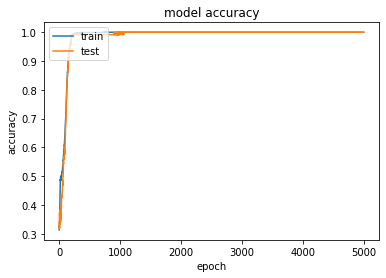

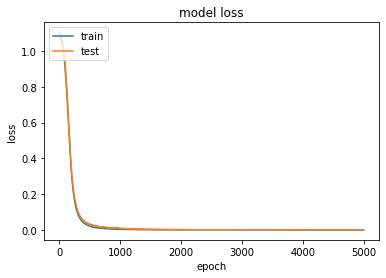

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test_oh, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [84]:
y_tilde = model.predict(x_test)
for i in range(len(x_test)):
  print(i, "Prediction: {}, True label: {}".format(y_tilde[i], y_test[i]))

4/4 [==============================] - 0s 3ms/step
0 Prediction: [9.4448060e-10 1.2869658e-18 1.0000000e+00], True label: [2.]
1 Prediction: [3.6472889e-10 4.0639185e-18 1.0000000e+00], True label: [2.]
2 Prediction: [1.02350356e-07 9.99999881e-01 4.91384071e-08], True label: [1.]
3 Prediction: [1.0000000e+00 2.1564244e-08 2.1681659e-08], True label: [0.]
4 Prediction: [1.1930271e-09 1.0000000e+00 4.2872653e-25], True label: [1.]
5 Prediction: [9.9999988e-01 1.0895326e-07 2.4688596e-09], True label: [0.]
6 Prediction: [2.5091511e-08 1.0000000e+00 6.0182547e-20], True label: [1.]
7 Prediction: [2.3714227e-07 3.5143292e-12 9.9999976e-01], True label: [2.]
8 Prediction: [1.000000e+00 4.763385e-08 4.141328e-08], True label: [0.]
9 Prediction: [8.3461401e-08 1.9114137e-21 9.9999988e-01], True label: [2.]
10 Prediction: [1.0000000e+00 1.0201218e-08 9.9581329e-11], True label: [0.]
11 Prediction: [3.2717433e-09 6.8774123e-21 1.0000000e+00], True label: [2.]
12 Prediction: [6.2997656e-09 1.000